# **PORTFOLIO OPTIMIZATION - USING PYOMO SOLVER**

‘Can a Member of Congress give you stock tips?’

Senator portfolio used for this exercise: James M. Inhofe - 👇


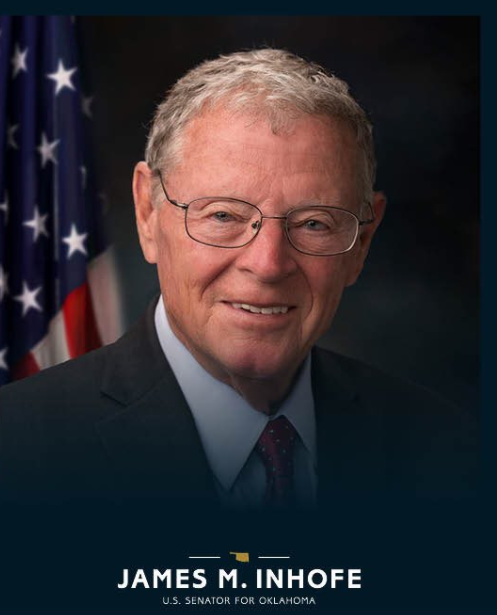

Source: https://twitter.com/JimInhofe

# **1: DATA PREPARATION & EDA** 

### **Importing required modules**

In [1]:
# helpful modules

import numpy as np #Importing numpy package
import pandas as pd #Importing pandas dataframe to work on data frames
import matplotlib.pyplot as plt #Importing matplot library for visualizations
from pylab import *  #pylab module also for visualizations
import datetime # for handling date and timestamps
import time # for handling times
from dateutil.relativedelta import relativedelta # to perform time difference
from matplotlib.pyplot import figure #importing pyplot module in matplotlib
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter  #Library to set ticks

# plotting
import seaborn as sns #Importing seaborn module for visualization

### **Installing stock-specific packages**

In [2]:
# some stock-specific packages

!pip install yahoo_fin #Install yahoo finance packages
!pip install requests_html #Installing a package to perform requests on html packages
import yahoo_fin.stock_info as si #importing stock info module

     |████████████████████████████████| 81 kB 3.4 MB/s 
     |████████████████████████████████| 83 kB 2.4 MB/s 
     |████████████████████████████████| 127 kB 54.8 MB/s 
     |████████████████████████████████| 103 kB 40.7 MB/s 
  Created wheel for fake-useragent: filename=fake_useragent-0.1.11-py3-none-any.whl size=13502 sha256=8133d959170af1bf5f3b286212e518e4c5f0c265d662e0b1be426605d4ed7c48
  Stored in directory: /root/.cache/pip/wheels/ed/f7/62/50ab6c9a0b5567267ab76a9daa9d06315704209b2c5d032031
  Created wheel for parse: filename=parse-1.19.0-py3-none-any.whl size=24591 sha256=48886b5712f834721352781c182928b88bab43b2859609da5306437042c30a26
  Stored in directory: /root/.cache/pip/wheels/9c/aa/cc/f2228050ccb40f22144b073f15a2c84f11204f29fc0dce028e
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6065 sha256=09d4ee84044b56f5cf1dd17b7b887fea0b014e7958c97fe19188182650f8111f
  Stored in directory: /root/.cache/pip/wheels/73/ad/a4/0dff4a6ef231fc0dfa12ffbac2a36ce

### **Installing pyomo for the IPOPT solver**

In [3]:
# install pyomo
!pip install -q pyomo # installing software packages for formulating optimization models
from pyomo.environ import * 

try:
    import google.colab
    try:
        from pyomo.environ import *
    except:
        !pip install -q pyomo
    if not 'ipopt_executable' in vars():
        !wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
        !unzip -o -q ipopt-linux64
        ipopt_executable = '/content/ipopt' # We are using the IPOPT Solver.
except:
    pass

     |████████████████████████████████| 9.2 MB 4.9 MB/s 
     |████████████████████████████████| 49 kB 4.4 MB/s 


### **Retrieving the data from Drive**

In [4]:
URL = 'https://drive.google.com/file/d/1Dzd7nHoiy5CVItKJ3rz70qn9V-ZKEvGl/view?usp=sharing' # retrieves the CSV data file and builds a dataframe

fixed_path = 'https://drive.google.com/uc?export=download&id='  # retrieves the CSV data and builds a dataframe

file_path = URL.split('/')[-2] # gets the unique identifier which is last from from second after the split

df = pd.read_csv(fixed_path + file_path) # combining the above two strings and fetch Dataframe

print(df.shape) # prints no. of rows and columns

(8879, 11)


**Reading the data stored to dataframe df**

In [5]:
df.head() # shows the first five instances from all of the data

,transaction_date,owner,ticker,asset_description,asset_type,type,amount,comment,senator,ptr_link,disclosure_date
0,09/30/2021,Joint,PG,Procter &amp; Gamble Company (The) Common Stock,Stock,Purchase,"$1,001 - $15,000",--,Thomas H Tuberville,https://efdsearch.senate.gov/search/view/ptr/a...,10/15/2021
1,09/30/2021,Joint,NFLX,"Netflix, Inc. - Common Stock",Stock,Purchase,"$1,001 - $15,000",--,Thomas H Tuberville,https://efdsearch.senate.gov/search/view/ptr/a...,10/15/2021
2,09/30/2021,Joint,MPWR,"Monolithic Power Systems, Inc. - Common Stock",Stock,Purchase,"$1,001 - $15,000",--,Thomas H Tuberville,https://efdsearch.senate.gov/search/view/ptr/a...,10/15/2021
3,09/30/2021,Joint,KEYS,Keysight Technologies Inc. Common Stock,Stock,Purchase,"$1,001 - $15,000",--,Thomas H Tuberville,https://efdsearch.senate.gov/search/view/ptr/a...,10/15/2021
4,09/30/2021,Joint,KLAC,KLA Corporation - Common Stock,Stock,Purchase,"$1,001 - $15,000",--,Thomas H Tuberville,https://efdsearch.senate.gov/search/view/ptr/a...,10/15/2021


**Fetching data related to the senator; James M Inhofe to df1**

In [6]:
df1 = df[df["senator"]=="James M Inhofe"] # filtering the data so we only get results for the senator 
print(df1.shape) # shows how many instances are left after the filter was used
df1.head() # shows the first five instances after the filter was used

(230, 11)


,transaction_date,owner,ticker,asset_description,asset_type,type,amount,comment,senator,ptr_link,disclosure_date
457,01/05/2021,Self,CRSP,CRISPR Therapeutics AG,Stock,Sale (Partial),"$1,001 - $15,000",--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/8...,01/15/2021
502,12/22/2020,Self,CRSP,CRISPR Therapeutics AG,Stock,Sale (Partial),"$50,001 - $100,000",--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/7...,12/23/2020
503,12/15/2020,Self,BLK,"BlackRock, Inc.",Stock,Sale (Partial),"$50,001 - $100,000",--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/7...,12/23/2020
932,07/15/2020,Self,AAPL,Apple Inc.,Stock,Sale (Partial),"$15,001 - $50,000",--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/9...,07/24/2020
933,07/15/2020,Self,AMZN,"Amazon.com, Inc.",Stock,Sale (Partial),"$15,001 - $50,000",--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/9...,07/24/2020


## **Data Manipulation**

**Changing the transaction_date and disclosure_date to datetime format**

In [7]:
df1['transaction_date'] = pd.to_datetime(df1['transaction_date']) # changing object to datetime dtype
df1['disclosure_date'] = pd.to_datetime(df1['disclosure_date']) # changing object to datetime dtype
df1.info() # gets the information about each column in the dataset

<class 'pandas.core.frame.DataFrame'>
Int64Index: 230 entries, 457 to 7632
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   transaction_date   230 non-null    datetime64[ns]
 1   owner              229 non-null    object        
 2   ticker             229 non-null    object        
 3   asset_description  230 non-null    object        
 4   asset_type         230 non-null    object        
 5   type               229 non-null    object        
 6   amount             230 non-null    object        
 7   comment            229 non-null    object        
 8   senator            230 non-null    object        
 9   ptr_link           230 non-null    object        
 10  disclosure_date    230 non-null    datetime64[ns]
dtypes: datetime64[ns](2), object(9)
memory usage: 21.6+ KB


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


**Manipulating insignificant values to useful data**

In [8]:
# Manipulating the 'amount' column

df1['amount'] = df1['amount'].str.split('-').str[-1] # splits the string on delimiter '-'
df1['amount'] = df1['amount'].str.split('$').str[-1] # splits the string on delimiter $
df1['amount'] = df1['amount'].str.replace(',', '') # removes ',' 
df1['amount'] = pd.to_numeric(df1['amount'], errors='coerce') # converting amount to numeric column
df1.head() # displays top 5 records


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

,transaction_date,owner,ticker,asset_description,asset_type,type,amount,comment,senator,ptr_link,disclosure_date
457,2021-01-05,Self,CRSP,CRISPR Therapeutics AG,Stock,Sale (Partial),15000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/8...,2021-01-15
502,2020-12-22,Self,CRSP,CRISPR Therapeutics AG,Stock,Sale (Partial),100000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/7...,2020-12-23
503,2020-12-15,Self,BLK,"BlackRock, Inc.",Stock,Sale (Partial),100000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/7...,2020-12-23
932,2020-07-15,Self,AAPL,Apple Inc.,Stock,Sale (Partial),50000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/9...,2020-07-24
933,2020-07-15,Self,AMZN,"Amazon.com, Inc.",Stock,Sale (Partial),50000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/9...,2020-07-24


**Viewing the unique ticker values**

In [9]:
print(df1["ticker"].nunique()) # prints number of unique records
df1["ticker"].unique() # prints unique values in a column 

91


array(['CRSP', 'BLK', 'AAPL', 'AMZN', 'BAM', 'V', 'MSFT', 'C', 'PYPL',
       'INTU', 'DHR', 'PG', 'BFAM', 'UNH', 'XBI', 'AIG', 'ISRG', '--',
       'TEL', 'LH', 'CLR', 'EDIT', 'DAL', 'KMX', 'BABA', 'ALB', 'MRK',
       'CELG', 'APTV', 'XPO', 'RTN', 'GE', 'NTLA', 'CRM', 'GOOGL', 'LEA',
       'BKNG', 'RSPP', 'ST', 'BMY', 'PEP', 'XOM', 'DFS', 'COHR', 'CHKP',
       'GILD', 'AGN', 'BUD', 'PCLN', 'XON', 'HBI', 'DIS', 'CVS', 'GM',
       'FLR', 'NFX', 'UL', 'JNJ', 'AMGN', 'SYF', 'CERN', 'WFC', 'ARW',
       'CTSH', 'A', 'CSX', 'PRGO', 'BBU', 'ESRX', 'BIIB', 'RRC', 'SWN',
       'ITC', 'CHK', 'COF', 'EMR', 'DISCK', 'QCOM', 'FANG', 'MSACX',
       'VADDX', 'NGIPX', 'WSTMX', 'VMIIX', 'VSMIX', 'ACSDX', 'MGEMX',
       'ABT', nan, 'ALTR', 'ETN', 'MCD'], dtype=object)

**Filtering the tickers without any details**

In [10]:
df2 = df1[df1["ticker"]=="--"] # filters records with ticker as "--"
df2.head(100) # prints first 100 rows

,transaction_date,owner,ticker,asset_description,asset_type,type,amount,comment,senator,ptr_link,disclosure_date
2750,2019-05-01,Self,--,GOOG - Alphabet Inc. C,Stock,Sale (Full),50000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/8...,2019-05-03
2751,2019-05-01,Self,--,GOOGL - Alphabet Inc. A,Stock,Sale (Full),50000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/8...,2019-05-03
3720,2018-07-12,Self,--,GILD,Stock,Sale (Full),100000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/1...,2018-07-25
5818,2016-12-15,Self,--,AGN-Allergan plc,Stock,Purchase,50000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/3...,2017-01-05
6806,2015-12-14,Self,--,FANG,Stock,Sale (Full),100000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/0...,2016-01-11
6807,2015-12-14,Self,--,CLR,Stock,Purchase,50000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/0...,2016-01-11
6808,2015-12-14,Self,--,CPN,Stock,Sale (Full),100000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/0...,2016-01-11
6924,2015-11-17,Self,--,RSPP,Stock,Sale (Full),50000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/3...,2015-12-09
7024,2015-10-28,Self,--,SWN,Stock,Purchase,100000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/a...,2015-11-16
7025,2015-10-28,Self,--,RRC,Stock,Sale (Partial),15000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/a...,2015-11-16


**Filling the ticker details from asset_description**

In [11]:
df2["ticker"] = df2["asset_description"] # assigning values/copying in Asset_desciption to ticker
df2['ticker'] = df2['ticker'].str.split('-').str[0].str.replace(' ', '') # splits the string from character '-' and fetch first word and save it in ticker column
df2.head() # prints the top 5 rows

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,transaction_date,owner,ticker,asset_description,asset_type,type,amount,comment,senator,ptr_link,disclosure_date
2750,2019-05-01,Self,GOOG,GOOG - Alphabet Inc. C,Stock,Sale (Full),50000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/8...,2019-05-03
2751,2019-05-01,Self,GOOGL,GOOGL - Alphabet Inc. A,Stock,Sale (Full),50000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/8...,2019-05-03
3720,2018-07-12,Self,GILD,GILD,Stock,Sale (Full),100000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/1...,2018-07-25
5818,2016-12-15,Self,AGN,AGN-Allergan plc,Stock,Purchase,50000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/3...,2017-01-05
6806,2015-12-14,Self,FANG,FANG,Stock,Sale (Full),100000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/0...,2016-01-11


**Re-checking for any non-ticker values**

In [12]:
df1 = df1[df1["ticker"] != "--"] # re-check if we have any values with ticker as "--"

**Adding df1 & df2 to fill-in all the ticker values**

In [13]:
df3 = pd.concat([df1, df2]) # Union/concat of two dataframes adds the rows from both the dataframes
df3.head() # prints the top 5 rows

,transaction_date,owner,ticker,asset_description,asset_type,type,amount,comment,senator,ptr_link,disclosure_date
457,2021-01-05,Self,CRSP,CRISPR Therapeutics AG,Stock,Sale (Partial),15000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/8...,2021-01-15
502,2020-12-22,Self,CRSP,CRISPR Therapeutics AG,Stock,Sale (Partial),100000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/7...,2020-12-23
503,2020-12-15,Self,BLK,"BlackRock, Inc.",Stock,Sale (Partial),100000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/7...,2020-12-23
932,2020-07-15,Self,AAPL,Apple Inc.,Stock,Sale (Partial),50000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/9...,2020-07-24
933,2020-07-15,Self,AMZN,"Amazon.com, Inc.",Stock,Sale (Partial),50000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/9...,2020-07-24


**Viewing the unique types**

In [14]:
print(df3["type"].nunique()) # number of unique value in type column
df3["type"].unique() # displays unique values in type column

3


array(['Sale (Partial)', 'Sale (Full)', 'Purchase', nan], dtype=object)

**Checking for nulls from merged dataframe df3**

In [15]:
df3.isnull().sum() # prints the count of nulls in all columns

transaction_date     0
owner                1
ticker               1
asset_description    0
asset_type           0
type                 1
amount               1
comment              1
senator              0
ptr_link             0
disclosure_date      0
dtype: int64

**Dropping any rows with null values**

In [16]:
df3.dropna(how='any', inplace=True) # drops all null values and by setting inplace = True wont change the index
df3.isnull().sum() # prints the count of nulls in each column

transaction_date     0
owner                0
ticker               0
asset_description    0
asset_type           0
type                 0
amount               0
comment              0
senator              0
ptr_link             0
disclosure_date      0
dtype: int64

**Viewing the shape and reading the df3**

In [17]:
print(df3.shape) # prints shape (number of rows and columns)
df3.head() # prints top 5 records

(229, 11)


,transaction_date,owner,ticker,asset_description,asset_type,type,amount,comment,senator,ptr_link,disclosure_date
457,2021-01-05,Self,CRSP,CRISPR Therapeutics AG,Stock,Sale (Partial),15000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/8...,2021-01-15
502,2020-12-22,Self,CRSP,CRISPR Therapeutics AG,Stock,Sale (Partial),100000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/7...,2020-12-23
503,2020-12-15,Self,BLK,"BlackRock, Inc.",Stock,Sale (Partial),100000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/7...,2020-12-23
932,2020-07-15,Self,AAPL,Apple Inc.,Stock,Sale (Partial),50000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/9...,2020-07-24
933,2020-07-15,Self,AMZN,"Amazon.com, Inc.",Stock,Sale (Partial),50000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/9...,2020-07-24


**Extracting month and year from the transaction date**

In [18]:
df3["month"] = df3["transaction_date"].dt.month_name() # extracting month name for analysis
df3["year"] = df3["transaction_date"].dt.year # extracting year for analysis
df3.head() # displays top 5 records

,transaction_date,owner,ticker,asset_description,asset_type,type,amount,comment,senator,ptr_link,disclosure_date,month,year
457,2021-01-05,Self,CRSP,CRISPR Therapeutics AG,Stock,Sale (Partial),15000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/8...,2021-01-15,January,2021
502,2020-12-22,Self,CRSP,CRISPR Therapeutics AG,Stock,Sale (Partial),100000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/7...,2020-12-23,December,2020
503,2020-12-15,Self,BLK,"BlackRock, Inc.",Stock,Sale (Partial),100000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/7...,2020-12-23,December,2020
932,2020-07-15,Self,AAPL,Apple Inc.,Stock,Sale (Partial),50000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/9...,2020-07-24,July,2020
933,2020-07-15,Self,AMZN,"Amazon.com, Inc.",Stock,Sale (Partial),50000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/9...,2020-07-24,July,2020


**Filtering the data till Mar-01-2020 and storing it to df32020**

In [19]:
df32020=df3[(df3["transaction_date"] <= "2020-03-01")]  # preparing training data where transaction data <= March 01st 2020
df32020.sort_values("transaction_date", ascending = False, inplace=True) # sorting values based on transaction_date in descending order 
df32020.head() # prints the top 5 rows

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,transaction_date,owner,ticker,asset_description,asset_type,type,amount,comment,senator,ptr_link,disclosure_date,month,year
1797,2020-02-20,Self,BAM,Brookfield Asset Management Inc.,Stock,Sale (Partial),100000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/0...,2020-03-13,February,2020
1931,2020-01-27,Self,INTU,Intuit Inc.,Stock,Sale (Full),100000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/f...,2020-02-14,January,2020
1932,2020-01-27,Self,DHR,Danaher Corporation,Stock,Sale (Full),100000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/f...,2020-02-14,January,2020
1933,2020-01-27,Self,BAM,Brookfield Asset Management Inc.,Stock,Sale (Partial),100000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/f...,2020-02-14,January,2020
1934,2020-01-27,Self,AAPL,Apple Inc.,Stock,Sale (Partial),50000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/f...,2020-02-14,January,2020


**Aggregating the above data till 2020 by month and type**

This is inorder to build dataframes to plot graphs on monthly data for each type against the amount

In [20]:
monvsamt = df32020.groupby(["month", "type"], sort = False).sum().reset_index() # calculating sum of amount by grouping on month and sales
monvsamt.head()  # prints top 5 records

,month,type,amount,year
0,February,Sale (Partial),450000.0,10089
1,January,Sale (Full),1800000.0,32298
2,January,Sale (Partial),500000.0,8078
3,September,Sale (Full),300000.0,8072
4,July,Sale (Full),570000.0,26204


**Create new dataframes of month vs type to refer for the plots**

In [21]:
monvspur = monvsamt[monvsamt["type"]=="Purchase"] # creating a dataframe for type as purchase
monvssale = monvsamt[monvsamt["type"]=="Sale (Full)"] # creating a dataframe for type as sale (full)
monvssalepart = monvsamt[monvsamt["type"]=="Sale (Partial)"] # creating a dataframe for type as Sale (partial)

## **Plot 1: Monthly Investment (Amount vs type (Purchase))**

This plot explains the monthly cumulative investment by the senator. From the graph, it can be observed that the senator has invested the highest in July. 

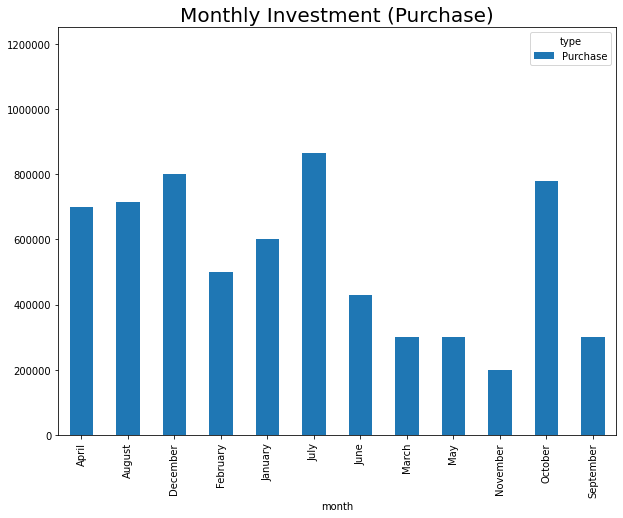

In [22]:
#plt.figure(figsize=(100,100)) # restricts the x and y axis dimensions of the overall figure layout
p1 = monvspur.pivot("month", "type", "amount").plot(kind="bar", figsize = (10, 7.5)) # plotting a bar chart
plt.ylim(0,1250000) # setting y-axis limit
p1.set_title("Monthly Investment (Purchase)", fontsize=20) # settting title
p1.yaxis.set_major_formatter(FormatStrFormatter('%.0f')) # formatter
plt.show() # to display the graph and avoid unwanted text above the graph


## **Plot 2: Monthly Sales (Amount vs type (Sale Full))**

This plot explains the monthly cumulative sales by the senator. From the graph, it can be observed that the senator has dramaticlly sold his stocks in the month of October in comparison to other months. A detailed analysis on the year and reason of the extreme sales are shown below through plot 4. One observation is regarding the high purchases in the months of October and December post sales in October. 

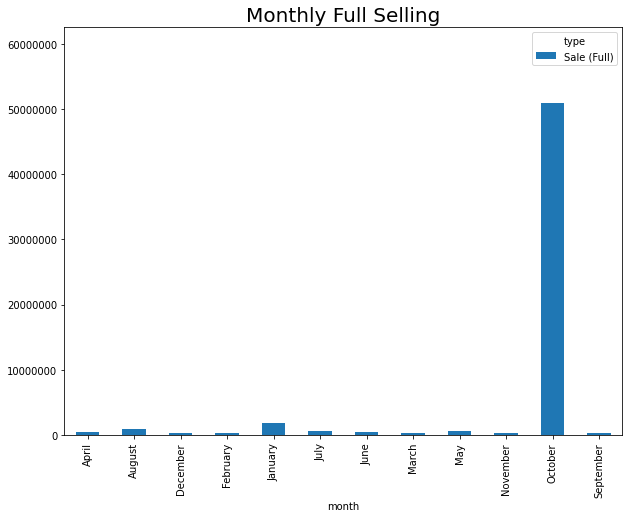

In [23]:
#plt.figure(figsize=(50,50)) # restricts the x and y axis dimensions of the overall figure layout
p2 = monvssale.pivot("month", "type", "amount").plot(kind='bar', figsize  = (10,7.5)) # plotting a bar chart
plt.ylim(0,62500000) # setting X-limit
p2.set_title("Monthly Full Selling", fontsize=20) # setting title
p2.yaxis.set_major_formatter(FormatStrFormatter('%.0f')) # formatting
plt.show() # to display the graph and avoid unwanted text above the graph

## **Plot 3: Monthly Sales (Amount vs type (Sale Partial))**

This plot explains the monthly cumulative ppartial sales by the senator. From the graph, it can be observed that the senator has partially sold his stocks more in the month of May in comparison to other months. We can see relate this to plot 1 where the sales are followed by purchase in July month poste high sale in May.

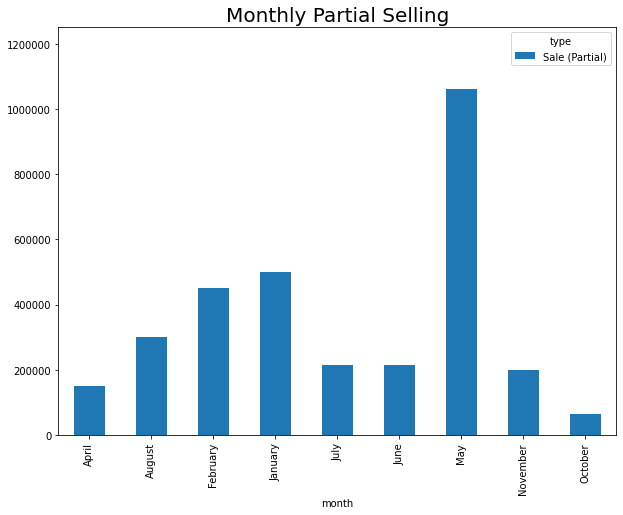

In [24]:
#plt.figure(figsize=(50,50)) # restricts the x and y axis dimensions of the overall figure layout
p3 = monvssalepart.pivot("month", "type", "amount").plot(kind='bar', figsize  = (10,7.5)) # plotting bar chart 
plt.ylim(0,1250000) # setting y limit
p3.set_title("Monthly Partial Selling", fontsize=20) # setting title
p3.yaxis.set_major_formatter(FormatStrFormatter('%.0f')) # setting y-axis
plt.show() # to display the graph and avoid unwanted text above the graph

##  **Analysis & Explanation for Plot 2**

In [25]:
yearvssale = df32020.groupby(["year", "month", "type"], sort = False).sum().reset_index() # aggregation of sales for each year, month, type 
yearvssale["mon-year"] = yearvssale["month"] + " " + yearvssale["year"].astype(str)  # concatinating Month and Year
yearvssalefull = yearvssale[yearvssale["type"]=="Sale (Full)"] # separating sale full data
yearvssalepart = yearvssale[yearvssale["type"]=="Sale (Partial)"] # separating sale partial data
yearvssalefull.head() # displays the top 5 rows

,year,month,type,amount,mon-year
1,2020,January,Sale (Full),600000.0,January 2020
3,2019,September,Sale (Full),100000.0,September 2019
4,2019,July,Sale (Full),100000.0,July 2019
5,2019,June,Sale (Full),50000.0,June 2019
6,2019,May,Sale (Full),150000.0,May 2019


## **Plot 4: Monthly Sales for each year from 2015 till 2020 (Amount vs type (Sale Full))**

This plot explains the cumulative sales by the senator with month & year details. From the plot, it can be observed that the senator has dramaticlly sold his stocks in October 2015 in comparison to other months.

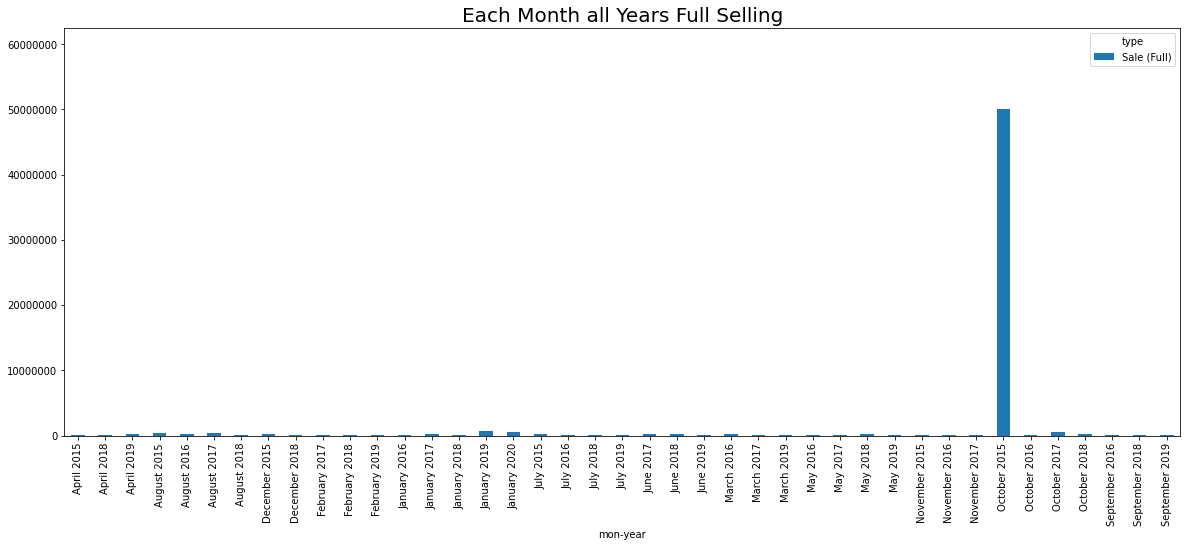

In [26]:
#plt.figure(figsize=(250,1000), dpi=500) # restricts the x and y axis dimensions of the overall figure layout
p4 = yearvssalefull.pivot("mon-year", "type", "amount").plot(kind='bar', figsize = (20,7.5)) # displaying bar chart
plt.ylim(0,62500000) # setting y limit
p4.set_title("Each Month all Years Full Selling", fontsize=20) # setting title
p4.yaxis.set_major_formatter(FormatStrFormatter('%.0f')) # setting y-axis
plt.show() # to display the graph and avoid unwanted text above the graph

**Filtering only the date with highest sales for the above plot**

In [27]:
df32020[(df32020["month"]=="October") & (df32020["year"]==2015) & (df32020["type"]=="Sale (Full)")] # fetching october 2015 record

,transaction_date,owner,ticker,asset_description,asset_type,type,amount,comment,senator,ptr_link,disclosure_date,month,year
7087,2015-10-05,Self,WFM,WFM,Stock,Sale (Full),50000000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/b...,2015-10-26,October,2015


**It can be observed that the WFM stock has been sold completely on 10-05-2015. Based on the research (screenshot below), it is noted that there is a sudden increase in WFM stock price on 10-02-2015 and the senator assessed a profit of ~8.3% i.e., upto 4 Mn by selling the stocks worth $ 50,000,000**

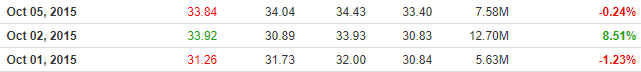

Source: https://www.investing.com/equities/whole-foods-mkt-inc-historical-data

## **Fetching the sector details for analysis**

In [28]:
URL = 'https://drive.google.com/file/d/1XyrQdYgLRvf7NhwKElZkY8SgzN2uBv5x/view?usp=sharing' # retrieves the CSV data file and builds a dataframe

fixed_path = 'https://drive.google.com/uc?export=download&id='  # retrieves the CSV data and build a dataframe

file_path = URL.split('/')[-2] # fetching unique identifier after split

stocksector = pd.read_csv(fixed_path + file_path) # reading the csv file

stocksector.head() # displays first 5 records

,ticker,sector
0,A,Health Care
1,AAL,Industrials
2,AAP,Consumer Discretionary
3,AAPL,Information Technology
4,ABBV,Health Care


**Merging the data of stocks till 2020 and sector data, viewing the nulls and dropping the same**

The nulls observed are mostly investment funds and stock data has been fully retained.

In [29]:
ts = pd.merge(df32020, stocksector, on = "ticker", how = "left") # joining Sector data and stock transaction data based on column ticker
print(ts.isnull().sum()) # checking for null values 
print(ts.shape) # checks data frame shape (rows and columns)
ts.head() # displays top 5 records

transaction_date      0
owner                 0
ticker                0
asset_description     0
asset_type            0
type                  0
amount                0
comment               0
senator               0
ptr_link              0
disclosure_date       0
month                 0
year                  0
sector               24
dtype: int64
(237, 14)


,transaction_date,owner,ticker,asset_description,asset_type,type,amount,comment,senator,ptr_link,disclosure_date,month,year,sector
0,2020-02-20,Self,BAM,Brookfield Asset Management Inc.,Stock,Sale (Partial),100000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/0...,2020-03-13,February,2020,Financials
1,2020-01-27,Self,INTU,Intuit Inc.,Stock,Sale (Full),100000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/f...,2020-02-14,January,2020,Information Technology
2,2020-01-27,Self,DHR,Danaher Corporation,Stock,Sale (Full),100000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/f...,2020-02-14,January,2020,Health Care
3,2020-01-27,Self,BAM,Brookfield Asset Management Inc.,Stock,Sale (Partial),100000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/f...,2020-02-14,January,2020,Financials
4,2020-01-27,Self,AAPL,Apple Inc.,Stock,Sale (Partial),50000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/f...,2020-02-14,January,2020,Information Technology


In [30]:
ts.dropna() # drop null values

,transaction_date,owner,ticker,asset_description,asset_type,type,amount,comment,senator,ptr_link,disclosure_date,month,year,sector
0,2020-02-20,Self,BAM,Brookfield Asset Management Inc.,Stock,Sale (Partial),100000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/0...,2020-03-13,February,2020,Financials
1,2020-01-27,Self,INTU,Intuit Inc.,Stock,Sale (Full),100000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/f...,2020-02-14,January,2020,Information Technology
2,2020-01-27,Self,DHR,Danaher Corporation,Stock,Sale (Full),100000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/f...,2020-02-14,January,2020,Health Care
3,2020-01-27,Self,BAM,Brookfield Asset Management Inc.,Stock,Sale (Partial),100000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/f...,2020-02-14,January,2020,Financials
4,2020-01-27,Self,AAPL,Apple Inc.,Stock,Sale (Partial),50000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/f...,2020-02-14,January,2020,Information Technology
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,2015-04-29,Self,AMZN,Amazon.com Inc. (NASDAQ),Stock,Sale (Partial),50000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/2...,2015-05-28,April,2015,Consumer Discretionary
233,2015-04-21,Self,WFC,Wells Fargo &amp; Company (NYSE),Stock,Sale (Partial),50000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/2...,2015-05-28,April,2015,Financials
234,2015-04-21,Self,EMR,Emerson Electric Co. (NYSE),Stock,Purchase,100000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/2...,2015-05-28,April,2015,Industrials
235,2015-04-14,Self,MCD,McDonald's Corp. (NYSE),Stock,Sale (Full),100000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/2...,2015-05-28,April,2015,Consumer Discretionary


**Filtering the data for purchase type so as to analyse the sectors most invested by the senator**

In [31]:
tspurchase = ts[ts["type"]=="Purchase"] # fetching records with type as purchase
dfsector = pd.DataFrame(tspurchase.groupby("sector")["amount"].sum()) # calculating sum of amount for each sector
dfsector.reset_index(inplace=True) # resetting index
dfsector # printing dataframe

,sector,amount
0,Communication Services,100000.0
1,Consumer Cyclical,300000.0
2,Consumer Defensive,150000.0
3,Consumer Discretionary,600000.0
4,Consumer Staples,50000.0
5,Corporate Governance,150000.0
6,Energy,880000.0
7,Financials,500000.0
8,Health Care,1465000.0
9,Industrials,880000.0


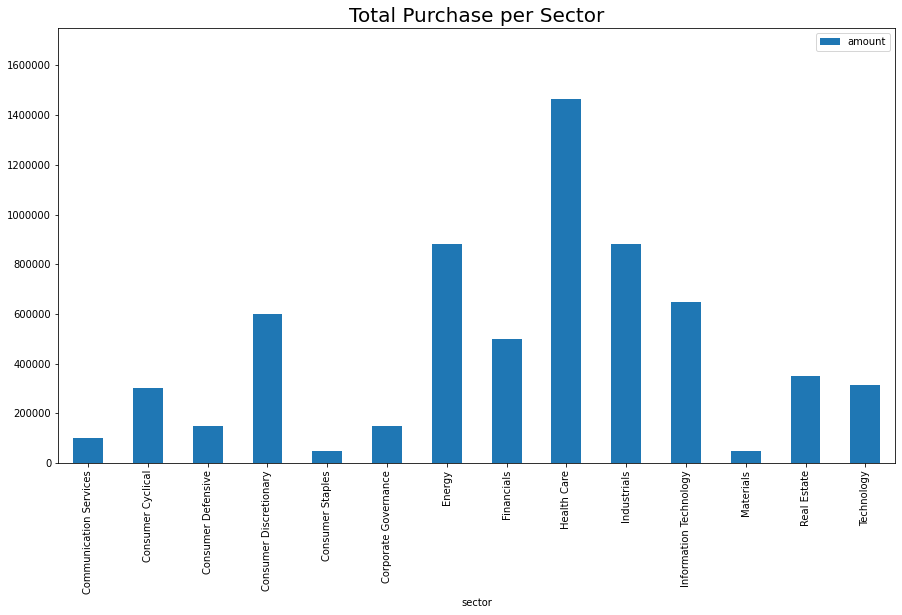

In [32]:
#plt.figure(figsize=(25,100), dpi = 50) # restricts the x and y axis dimensions of the overall figure layout
p5 = dfsector.plot("sector", "amount", kind = "bar", figsize = (15,8)) # plotting bar chart
plt.ylim(0,1750000) # setting y-axis linmit
p5.set_title("Total Purchase per Sector", fontsize=20) # setting title
p5.yaxis.set_major_formatter(FormatStrFormatter('%.0f')) # formatter 
plt.show()# to display the graph and avoid unwanted text above the graph

## **Methodology for top 10 stock selection**

The above 10 stocks are calculated basis the following procedure:

1. ***Rank tickers based on transaction date*** - Group the data till 2020 (df32020) by transaction date in descending order and rank the latest data with rank 1.
2. ***Filter the rank 1 and where type is sale(partial) & purchase*** - Fetch all the rows with rank 1. These stocks are considered to be inactive as the latest date has type Sale (Full) and hence the same doesn't exist in the portfolio of the senator as of Mar-01-2020. 
  ***Filter the Purchase and sale(partial)*** After the step 3, the dataframe is left with stocks which are currently active in the portfolio.
3. ***Saving the tickers*** - from above step to a dataframe df5.
4. ***Merge on ticker*** - Now, merging the df3 & df5 (where df3 is the dataframe with the past details of all tickers) to retrieve the amount details for these stocks.
5. ***Group by the ticker and type, sum amounts.*** 
6. ***Downloading the last one year prices to see growth using yahoo finance API*** - Checking each stock on yahoo to find the active stocks alone and delete those that do not exist now.
7. ***Getting the top 10 stocks based on growth*** - Retaining the top 10 stocks from the above step with highest growth in 2019-2020.

**Step 1:** **Rank tickers based on transaction date** - Group the data till 2020 (df32020) by transaction date in descending order and rank the latest data with rank 1.


In [33]:
df32020["rank"] = df32020.groupby("ticker")["transaction_date"].rank(ascending=False) # creating a new column rank and ranking based on transaction date
df32020["ticker"].nunique() # counting total unique records
df32020[df32020["rank"]==1] # displaying records with Rank 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,transaction_date,owner,ticker,asset_description,asset_type,type,amount,comment,senator,ptr_link,disclosure_date,month,year,rank
1797,2020-02-20,Self,BAM,Brookfield Asset Management Inc.,Stock,Sale (Partial),100000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/0...,2020-03-13,February,2020,1.0
1931,2020-01-27,Self,INTU,Intuit Inc.,Stock,Sale (Full),100000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/f...,2020-02-14,January,2020,1.0
1932,2020-01-27,Self,DHR,Danaher Corporation,Stock,Sale (Full),100000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/f...,2020-02-14,January,2020,1.0
1934,2020-01-27,Self,AAPL,Apple Inc.,Stock,Sale (Partial),50000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/f...,2020-02-14,January,2020,1.0
1930,2020-01-27,Self,PYPL,"PayPal Holdings, Inc.",Stock,Sale (Full),50000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/f...,2020-02-14,January,2020,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7424,2015-07-09,Self,MGEMX,Morgan Stanley Inst Emerging Mkts I (NASDAQ),Stock,Sale (Full),15000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/1...,2015-07-15,July,2015,1.0
7431,2015-07-09,Self,ABT,Abbott Laboratories (NYSE),Stock,Sale (Full),100000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/1...,2015-07-15,July,2015,1.0
7626,2015-05-21,Self,ALTR,Altera Corp. (NASDAQ),Stock,Sale (Partial),50000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/2...,2015-05-28,May,2015,1.0
7632,2015-04-14,Self,MCD,McDonald's Corp. (NYSE),Stock,Sale (Full),100000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/2...,2015-05-28,April,2015,1.0


**We can see that there are around 80 rows with type as Sale (Full). We are filtering these out!**

In [34]:
df32020[(df32020["type"]=="Sale (Full)") & (df32020["rank"]==1)] # displaying records with rank 1 and sale full

,transaction_date,owner,ticker,asset_description,asset_type,type,amount,comment,senator,ptr_link,disclosure_date,month,year,rank
1931,2020-01-27,Self,INTU,Intuit Inc.,Stock,Sale (Full),100000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/f...,2020-02-14,January,2020,1.0
1932,2020-01-27,Self,DHR,Danaher Corporation,Stock,Sale (Full),100000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/f...,2020-02-14,January,2020,1.0
1930,2020-01-27,Self,PYPL,"PayPal Holdings, Inc.",Stock,Sale (Full),50000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/f...,2020-02-14,January,2020,1.0
2010,2020-01-13,Self,PG,The Procter &amp; Gamble Company,Stock,Sale (Full),250000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/2...,2020-01-23,January,2020,1.0
2011,2020-01-13,Self,BFAM,Bright Horizons Family Solutions Inc.,Stock,Sale (Full),100000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/2...,2020-01-23,January,2020,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7423,2015-07-09,Self,ACSDX,Invesco Comstock Y (NASDAQ),Stock,Sale (Full),15000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/1...,2015-07-15,July,2015,1.0
7424,2015-07-09,Self,MGEMX,Morgan Stanley Inst Emerging Mkts I (NASDAQ),Stock,Sale (Full),15000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/1...,2015-07-15,July,2015,1.0
7431,2015-07-09,Self,ABT,Abbott Laboratories (NYSE),Stock,Sale (Full),100000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/1...,2015-07-15,July,2015,1.0
7632,2015-04-14,Self,MCD,McDonald's Corp. (NYSE),Stock,Sale (Full),100000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/2...,2015-05-28,April,2015,1.0


**Step 2: Filter the rank 1 & Filter out those where type is sale(full)** - Fetching all the rows with rank 1 and where sale is not full and purchase types. These stocks are considered to be inactive as the latest date has type Sale (Full) and hence the same doesn't exist in the portfolio of the senator as of Mar-01-2020. 

In [35]:
df4 = df32020[(df32020["type"]!="Sale (Full)") & (df32020["rank"]==1)] # filtering rank 1 values where type is sale partial and purchase for into df4
df4 # printing df4 dataframe

,transaction_date,owner,ticker,asset_description,asset_type,type,amount,comment,senator,ptr_link,disclosure_date,month,year,rank
1797,2020-02-20,Self,BAM,Brookfield Asset Management Inc.,Stock,Sale (Partial),100000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/0...,2020-03-13,February,2020,1.0
1934,2020-01-27,Self,AAPL,Apple Inc.,Stock,Sale (Partial),50000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/f...,2020-02-14,January,2020,1.0
3115,2019-01-15,Self,V,Visa Inc.,Stock,Sale (Partial),100000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/9...,2019-01-17,January,2019,1.0
3116,2019-01-15,Self,AMZN,"Amazon.com, Inc.",Stock,Sale (Partial),250000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/9...,2019-01-17,January,2019,1.0
3253,2018-12-11,Self,RTN,Raytheon Company,Stock,Purchase,100000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/3...,2018-12-12,December,2018,1.0
3824,2018-06-19,Self,CRSP,CRISPR Therapeutics AG,Stock,Sale (Partial),50000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/7...,2018-06-20,June,2018,1.0
4075,2018-05-03,Self,BLK,"BlackRock, Inc.",Stock,Sale (Partial),50000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/8...,2018-05-14,May,2018,1.0
4072,2018-05-03,Self,C,Citigroup Inc.,Stock,Sale (Partial),15000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/8...,2018-05-14,May,2018,1.0
4064,2018-05-03,Self,PEP,"PepsiCo, Inc.",Stock,Sale (Partial),50000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/8...,2018-05-14,May,2018,1.0
4524,2017-11-13,Self,PCLN,The Priceline Group Inc.,Stock,Sale (Partial),100000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/4...,2017-12-13,November,2017,1.0


**Step 3: Saving the tickers** from above step to a dataframe df5.

In [36]:
df5 = pd.DataFrame(df4["ticker"]) # saving only ticker column into df5
df5.head() # display top 5 records

,ticker
1797,BAM
1934,AAPL
3115,V
3116,AMZN
3253,RTN


**Step 4: Merge on ticker** - Now, merging the df3 & df5 (where df3 is the dataframe with the past details of all tickers) to retrieve the amount details for these stocks.


In [37]:
dfactive = pd.merge(df5, df32020, on = "ticker", how = "left") # left join between df5 and df32020
dfactive.head() # displays top 5 rows from dataframe dfactive

,ticker,transaction_date,owner,asset_description,asset_type,type,amount,comment,senator,ptr_link,disclosure_date,month,year,rank
0,BAM,2020-02-20,Self,Brookfield Asset Management Inc.,Stock,Sale (Partial),100000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/0...,2020-03-13,February,2020,1.0
1,BAM,2020-01-27,Self,Brookfield Asset Management Inc.,Stock,Sale (Partial),100000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/f...,2020-02-14,January,2020,2.0
2,BAM,2018-08-14,Self,Brookfield Asset Management Inc.,Stock,Sale (Partial),50000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/4...,2018-08-20,August,2018,3.0
3,BAM,2018-05-03,Self,Brookfield Asset Management Inc.,Stock,Sale (Partial),50000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/8...,2018-05-14,May,2018,4.0
4,AAPL,2020-01-27,Self,Apple Inc.,Stock,Sale (Partial),50000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/f...,2020-02-14,January,2020,1.0


**Looking at the active stocks..**

In [38]:
print(dfactive["ticker"].nunique()) # printing the count of unique tickers
dfactive["ticker"].unique() # returns the unique tickers

13


array(['BAM', 'AAPL', 'V', 'AMZN', 'RTN', 'CRSP', 'BLK', 'C', 'PEP',
       'PCLN', 'DISCK', 'QCOM', 'ALTR'], dtype=object)

In [39]:
dfactive.loc[dfactive["type"].str.contains("Sale"), "type2"] = "Sale" # renaming all Sale Partial and Sale Full as Sale in a new column type 2
dfactive.loc[dfactive["type"].str.contains("Purchase"), "type2"] = "Purchase" # copying Purchase data from type to type 2 column
dfactive.head() # displays the first 5 records

,ticker,transaction_date,owner,asset_description,asset_type,type,amount,comment,senator,ptr_link,disclosure_date,month,year,rank,type2
0,BAM,2020-02-20,Self,Brookfield Asset Management Inc.,Stock,Sale (Partial),100000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/0...,2020-03-13,February,2020,1.0,Sale
1,BAM,2020-01-27,Self,Brookfield Asset Management Inc.,Stock,Sale (Partial),100000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/f...,2020-02-14,January,2020,2.0,Sale
2,BAM,2018-08-14,Self,Brookfield Asset Management Inc.,Stock,Sale (Partial),50000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/4...,2018-08-20,August,2018,3.0,Sale
3,BAM,2018-05-03,Self,Brookfield Asset Management Inc.,Stock,Sale (Partial),50000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/8...,2018-05-14,May,2018,4.0,Sale
4,AAPL,2020-01-27,Self,Apple Inc.,Stock,Sale (Partial),50000.0,--,James M Inhofe,https://efdsearch.senate.gov/search/view/ptr/f...,2020-02-14,January,2020,1.0,Sale


**Step 5: Group by the ticker and type and sum amounts**

In [40]:
dfactivestocks = pd.DataFrame(dfactive.groupby(["ticker", "type2"])["amount"].sum()) # aggregating the amount on ticker and type
dfactivestocks.reset_index(inplace=True) # reseting the index
dfactivestocks # displays dataframe

,ticker,type2,amount
0,AAPL,Purchase,50000.0
1,AAPL,Sale,150000.0
2,ALTR,Sale,50000.0
3,AMZN,Sale,300000.0
4,BAM,Sale,300000.0
5,BLK,Purchase,50000.0
6,BLK,Sale,115000.0
7,C,Purchase,200000.0
8,C,Sale,115000.0
9,CRSP,Purchase,50000.0


**Saving the tickers to a list**

In [41]:
dfactivestocks["ticker"].values.tolist() # converting the data elements of array(ticker) into list

['AAPL',
 'AAPL',
 'ALTR',
 'AMZN',
 'BAM',
 'BLK',
 'BLK',
 'C',
 'C',
 'CRSP',
 'CRSP',
 'DISCK',
 'PCLN',
 'PCLN',
 'PEP',
 'QCOM',
 'RTN',
 'V']

**Step 6: Downloading the last one year prices to see growth using yahoo finance API** - checking each stock on yahoo to find the active stocks alone and delete those that do not exist now. After checking for each stock, we see that RTN from the list cannot fetch data from yahoo and hence dropped the same.

In [42]:
tickers_list = ['AAPL', 'ALTR', 'AMZN', 'BAM', 'BLK', 'CRSP', 'DISCK', 'GOOGL', 'MSFT', 'PEP', 'QCOM', 'V']

# pull historical price data for each stocks 

dfactivestocks_prices = {ticker : si.get_data(ticker, start_date = '05/01/2019', end_date='06/01/2020', interval='1mo') for ticker in tickers_list} # considering  monthly stocks between 1st May 2019 to 1st June 2020
dfactivestocks_prices # displays the data dictionary

{'AAPL':                  open       high        low  ...   adjclose      volume  ticker
 2019-05-01  52.470001  53.827499  43.747501  ...  42.670734  2957826400    AAPL
 2019-06-01  43.900002  50.392502  42.567501  ...  48.425846  2060874800    AAPL
 2019-07-01  50.792500  55.342499  49.602501  ...  52.125309  1895406800    AAPL
 2019-08-01  53.474998  54.507500  48.145000  ...  51.073227  2724326400    AAPL
 2019-09-01  51.607498  56.605000  51.055000  ...  55.007805  2170268400    AAPL
 2019-10-01  56.267502  62.437500  53.782501  ...  61.096317  2433210800    AAPL
 2019-11-01  62.384998  67.000000  62.290001  ...  65.637520  1793326000    AAPL
 2019-12-01  66.817497  73.492500  64.072502  ...  72.337990  2388794800    AAPL
 2020-01-01  74.059998  81.962502  73.187500  ...  76.244957  2934370400    AAPL
 2020-02-01  76.074997  81.805000  64.092499  ...  67.339729  3019279200    AAPL
 2020-03-01  70.570000  76.000000  53.152500  ...  62.790684  6280072400    AAPL
 2020-04-01  61.6250

**Retrieving the adjusted close price for the stocks above**

In [43]:
prep_data = pd.DataFrame(dfactivestocks_prices['AAPL']['adjclose']).rename(columns = {"adjclose":"AAPL"}) # creating prep_data dataframe 

# combine all the tickers (all the rest of the samples)

for i in tickers_list[1:]:
  prep_data[i] = pd.DataFrame(dfactivestocks_prices[i]['adjclose']) # runs the loop for all the values in tickers list
prep_data # displays the data dictionary

,AAPL,ALTR,AMZN,BAM,BLK,CRSP,DISCK,GOOGL,MSFT,PEP,QCOM,V
2019-05-01,42.670734,38.110001,1775.069946,29.592865,388.558838,35.570000,25.639999,1106.500000,120.108582,118.314377,62.410015,158.624435
2019-06-01,48.425846,40.389999,1893.630005,30.945272,438.807068,47.099998,28.450001,1082.800049,130.573273,121.207542,71.049530,170.901947
2019-07-01,52.125309,41.610001,1866.780029,31.735420,440.638763,50.689999,28.240000,1218.199951,132.824875,119.003738,68.956184,175.284027
2019-08-01,51.073227,34.360001,1776.290039,33.425819,398.127594,46.209999,26.030001,1190.530029,134.374695,127.309135,73.301277,178.061035
2019-09-01,55.007805,34.619999,1735.910034,34.492142,419.873108,40.990002,24.620001,1221.140015,135.966354,127.653633,71.896904,169.629852
2019-10-01,61.096317,36.869999,1776.660034,35.895473,438.484375,50.369999,25.240000,1258.800049,140.210724,128.601425,76.419823,176.385071
2019-11-01,65.637520,33.169998,1800.800049,37.948505,470.024445,71.650002,30.520000,1304.089966,148.044235,127.345131,79.374390,181.956863
2019-12-01,72.337990,35.910000,1847.839966,37.655697,477.422760,60.904999,30.490000,1339.390015,154.749741,128.132645,83.820496,185.610321
2020-01-01,76.244957,36.950001,2008.719971,39.877251,504.252441,51.950001,27.770000,1432.780029,167.045303,134.081085,81.674850,196.545456
2020-02-01,67.339729,34.799999,1883.750000,39.062893,442.730408,53.450001,25.100000,1339.250000,158.979095,124.649498,74.963554,179.545151


In [44]:
prep_data.iloc[[0,-1]] # displays 1st and last row

,AAPL,ALTR,AMZN,BAM,BLK,CRSP,DISCK,GOOGL,MSFT,PEP,QCOM,V
2019-05-01,42.670734,38.110001,1775.069946,29.592865,388.558838,35.570000,25.639999,1106.50000,120.108582,118.314377,62.410015,158.624435
2020-05-01,78.507492,39.090000,2442.370117,30.732777,509.321075,64.580002,19.590000,1433.52002,180.312927,125.034958,78.049591,193.140213


**Step 7: Getting the top 10 stocks based on growth** - Retaining the top 10 stocks from the above step with highest growth in 2019-2020.


In [45]:
top12stocks = pd.DataFrame((prep_data.iloc[-1,:]-prep_data.iloc[0,:])*100/prep_data.iloc[0,:]).reset_index() # calculating the percentage change from 2019 till 2020
top12stocks # displays the dataframe

,index,0
0,AAPL,83.984394
1,ALTR,2.571502
2,AMZN,37.592894
3,BAM,3.851981
4,BLK,31.079524
5,CRSP,81.557499
6,DISCK,-23.595941
7,GOOGL,29.554453
8,MSFT,50.124933
9,PEP,5.680274


**Renaming the columns and bringing out a useful dataframe**

In [46]:
top12stocks.rename(columns={"index": "ticker", 0: "YoY growth (2019-2020)"},inplace=True) # renaming the aggregate amount as YoY growth (2019 - 2020)
top12stocks.sort_values("YoY growth (2019-2020)", ascending = False, inplace=True) # sorting the values on YoY growth (2019 - 2020)
top12stocks.reset_index(drop=True, inplace=True) # resetting the index
top12stocks # displays the top12stocks dataframe

,ticker,YoY growth (2019-2020)
0,AAPL,83.984394
1,CRSP,81.557499
2,MSFT,50.124933
3,AMZN,37.592894
4,BLK,31.079524
5,GOOGL,29.554453
6,QCOM,25.059401
7,V,21.759433
8,PEP,5.680274
9,BAM,3.851981


**Finally, the top 10 stocks based on the above analysis are:**

In [47]:
top10stocks = top12stocks.iloc[0:10] # assigning the top12stocks to new dataframe, by considering only 10 stocks based on the year-on-year growth
top10stocks # displays the df top10stocks

,ticker,YoY growth (2019-2020)
0,AAPL,83.984394
1,CRSP,81.557499
2,MSFT,50.124933
3,AMZN,37.592894
4,BLK,31.079524
5,GOOGL,29.554453
6,QCOM,25.059401
7,V,21.759433
8,PEP,5.680274
9,BAM,3.851981


**Merging the top 10 stocks with sectors to see the sector which generates most retuurns. From the ouput table below, we can say that Information Technology has highest growth from 2015 till Mar-01-2020 followed by Health Care.** 

In [48]:
top10sector = pd.merge(top10stocks, stocksector, on=["ticker"], how = "left") # left join between top10stocks and stocksector on the ticker column
top10sector # displays df top10sector

,ticker,YoY growth (2019-2020),sector
0,AAPL,83.984394,Information Technology
1,CRSP,81.557499,Health Care
2,MSFT,50.124933,Information Technology
3,AMZN,37.592894,Consumer Discretionary
4,BLK,31.079524,Financials
5,GOOGL,29.554453,Communication Services
6,QCOM,25.059401,Information Technology
7,V,21.759433,Information Technology
8,PEP,5.680274,Consumer Staples
9,BAM,3.851981,Financials


**Downloading the last 5 years prices to see growth using yahoo finance API** 

-- Fetch top stocks monthly data

In [51]:
tickers_list = ['AAPL', 'AMZN', 'BAM', 'BLK', 'CRSP', 'GOOGL', 'MSFT', 'PEP', 'QCOM', 'V']

# pull historical price data for each stocks 

EDA_External = {ticker : si.get_data(ticker, start_date = '05/01/2015', end_date='06/01/2020', interval='1mo') for ticker in tickers_list} # considering  monthly stocks between 1st May 2019 to 1st June 2020
EDA_External # displays the data dictionary

JSONDecodeError: ignored

**Retrieving the adjusted close price for the stocks above**

In [52]:
prep_data_2015 = pd.DataFrame(EDA_External['AAPL']['adjclose']).rename(columns = {"adjclose":"AAPL"}) # creating prep_data dataframe 

# combine all the tickers (all the rest of the samples)

for i in tickers_list[1:]:
  prep_data_2015[i] = pd.DataFrame(EDA_External[i]['adjclose']) # runs the loop for all the values in tickers list
prep_data_2015 # displays the data dictionary

,AAPL,AMZN,BAM,BLK,CRSP,GOOGL,MSFT,PEP,QCOM,V
2015-05-01,29.604244,429.230011,21.038725,309.272369,NaN,545.320007,41.575722,79.103035,56.063511,65.650764
2015-06-01,28.621206,434.089996,20.840950,292.531158,NaN,540.039978,39.425896,76.568237,50.391190,64.300575
2015-07-01,27.678801,536.150024,20.781284,286.106537,NaN,657.500000,41.703041,79.620148,52.166618,72.143021
2015-08-01,25.730104,512.890015,18.764610,257.310486,NaN,647.820007,38.863304,76.793976,45.839222,68.274460
2015-09-01,25.282700,511.890015,18.830536,254.841934,NaN,638.369995,39.784756,77.926102,43.897007,66.813347
...,...,...,...,...,...,...,...,...,...,...
2020-01-01,76.244957,2008.719971,39.877251,504.252441,51.950001,1432.780029,167.045319,134.081055,81.674858,196.545441
2020-02-01,67.339729,1883.750000,39.062893,442.730438,53.450001,1339.250000,158.979111,124.649506,74.963554,179.545151
2020-03-01,62.790684,1949.719971,28.909981,420.699585,42.410000,1161.949951,155.182266,113.386391,64.767365,159.387161
2020-04-01,72.546700,2474.000000,33.143574,483.693237,49.200001,1346.699951,176.337677,125.738289,75.916924,176.797882


## **Plot 5: Each Stock Trend from 2015 till 2020**

The subplots shows us the trend for each stock from 2015 to 2020. As we can see most of the stocks has the deep dip (except AMZN) during first quarter pf 2020. This can be traced to the beginning of pandemic, COVID - 19 period. It is well-known fact that Amazon (AMZN) is one of the biggest winners of Wallstreet from COVID!No company’s stock market value has benefited more than Amazon. Monness Crespi analyst Brian White has mentioned, "During this crisis, Amazon has proven irreplaceable in delivering the daily necessities to people around the world, a fact that we believe will increase the number of customers on the platform, expand the list of products purchased by existing customers, accelerate the shift to ecommerce at large and enhance the company’s brand." White is among 49 analysts who recommend buying Amazon’s shares, according to Refinitiv. Just two analysts have “hold” ratings and none recommend selling.

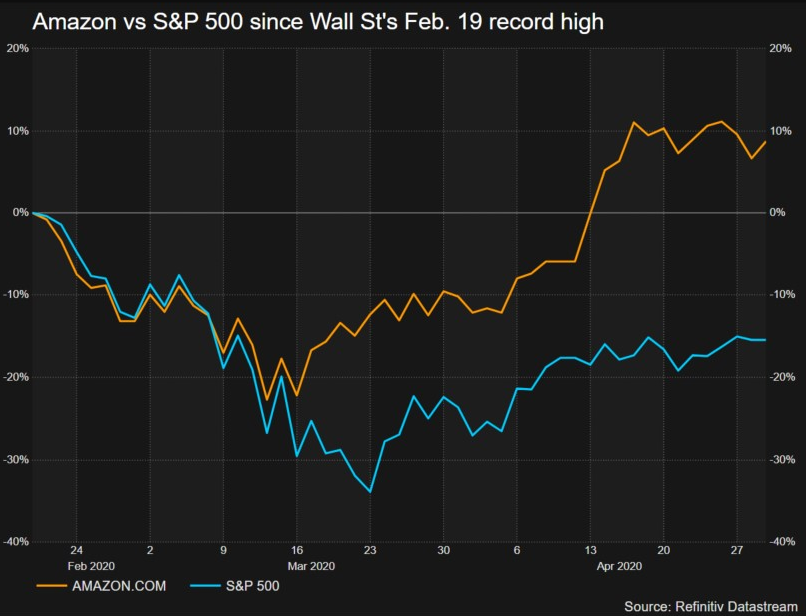

Source: https://www.reuters.com/article/us-amazon-stocks/amazon-is-wall-streets-biggest-winner-from-coronavirus-idUSKBN22B2ZU

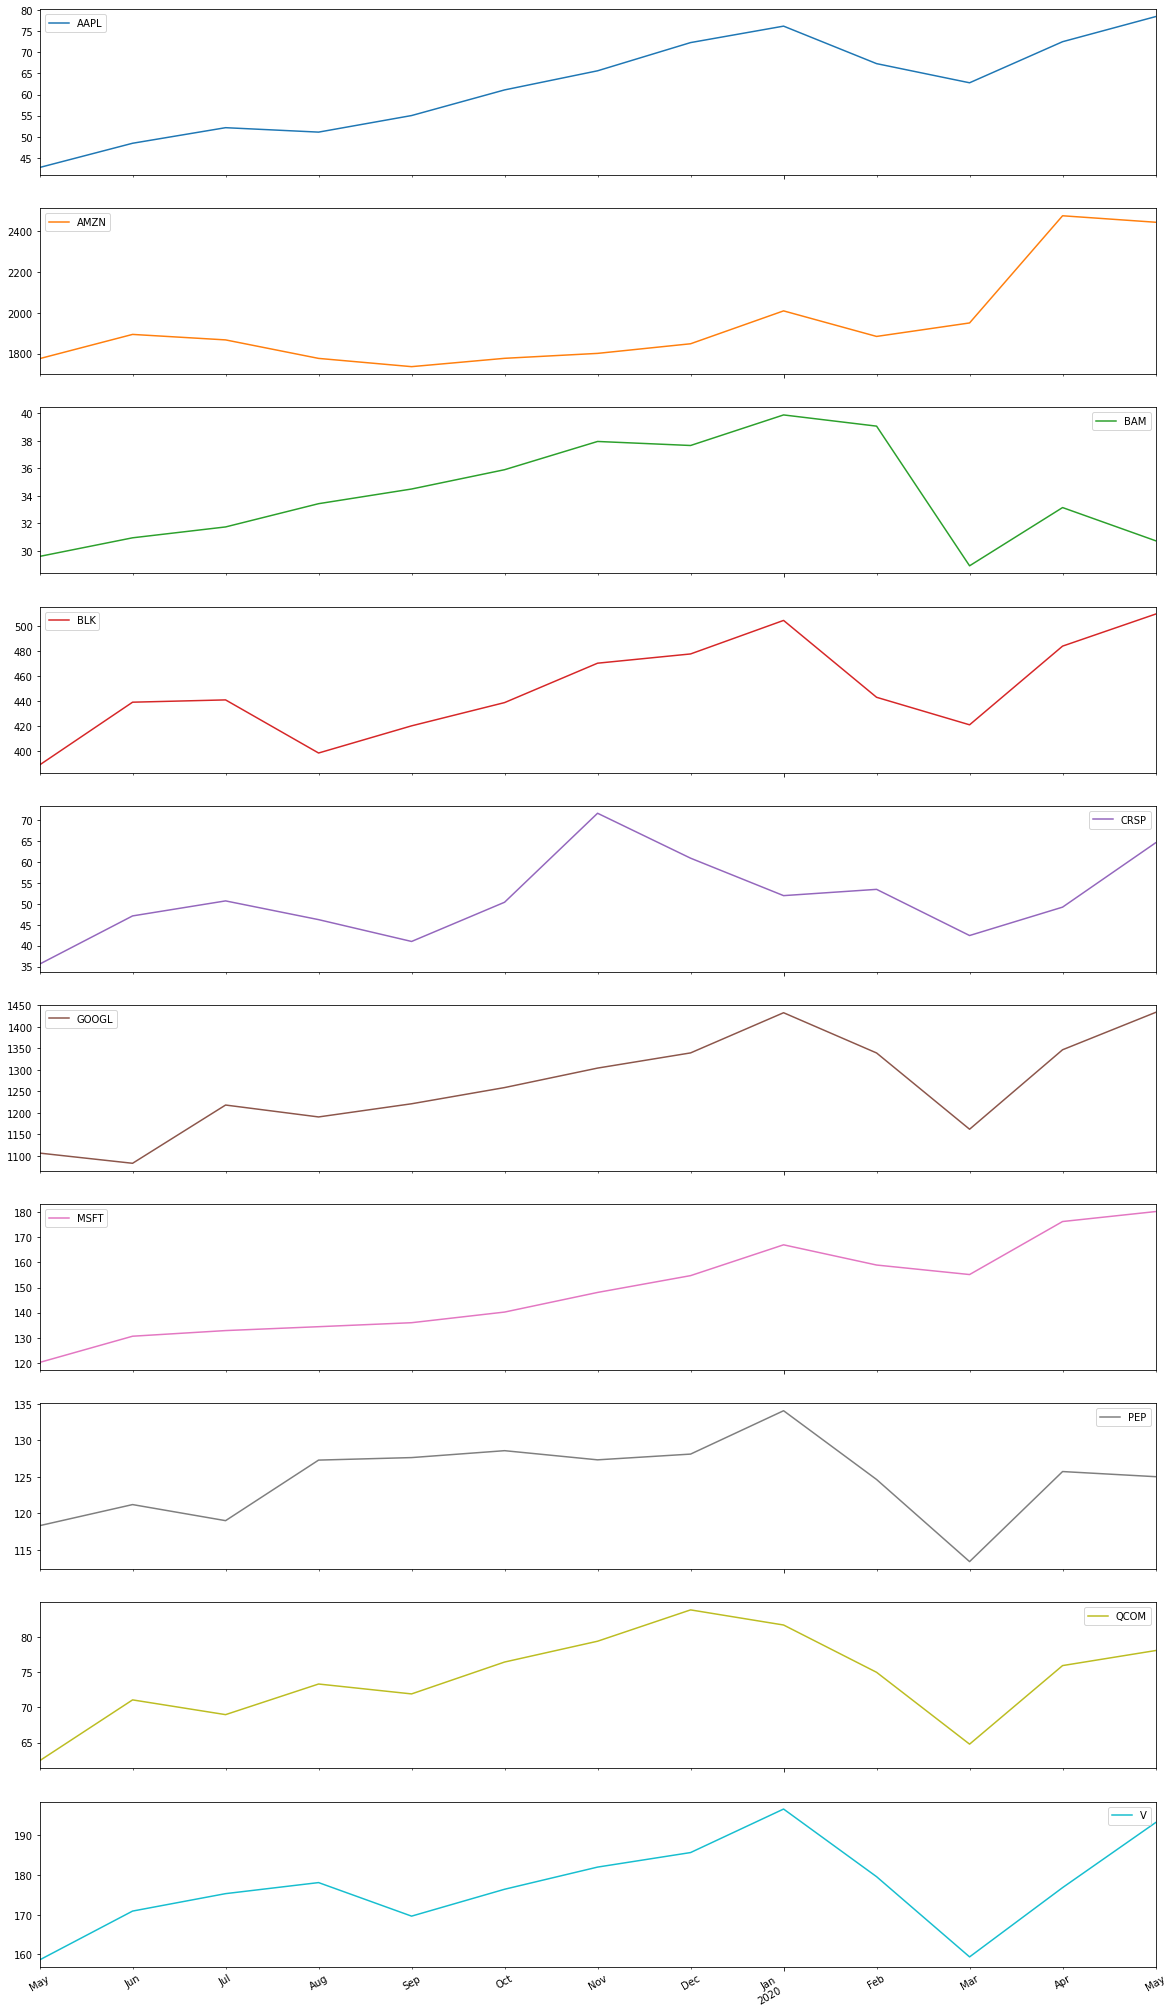

In [53]:
cols_plot = list(prep_data_2015.columns)
axes = prep_data[cols_plot].plot(subplots = True, figsize = (20,40))
plt.show()

## **Data pre-processing for model building**

**Storing the top 10 tickers to a list and downloading the historic data for those top 10 stocks**

In [55]:
ticker_list = top10sector["ticker"] # storing the list of tickers from top10sector dataframe

# pull daily historical price data for each stocks 

histdata = {ticker : si.get_data(ticker, start_date = '01/01/2015', end_date='03/01/2020', interval='1d') for ticker in ticker_list} # considering tickers in daily intervals between 1st Jan 2015 to 1st March 2020
histdata # displays the data dictionary 

{'AAPL':                  open       high        low  ...   adjclose     volume  ticker
 2015-01-02  27.847500  27.860001  26.837500  ...  24.745995  212818400    AAPL
 2015-01-05  27.072500  27.162500  26.352501  ...  24.048861  257142000    AAPL
 2015-01-06  26.635000  26.857500  26.157499  ...  24.051126  263188400    AAPL
 2015-01-07  26.799999  27.049999  26.674999  ...  24.388376  160423600    AAPL
 2015-01-08  27.307501  28.037500  27.174999  ...  25.325430  237458000    AAPL
 ...               ...        ...        ...  ...        ...        ...     ...
 2020-02-24  74.315002  76.044998  72.307503  ...  73.628235  222195200    AAPL
 2020-02-25  75.237503  75.632500  71.532501  ...  71.134285  230673600    AAPL
 2020-02-26  71.632500  74.470001  71.625000  ...  72.262741  198054800    AAPL
 2020-02-27  70.275002  71.500000  68.239998  ...  67.539062  320605600    AAPL
 2020-02-28  64.315002  69.602501  64.092499  ...  67.499535  426510000    AAPL
 
 [1298 rows x 7 columns],
 'AM

**Retrieving only the adjusted close price from the above data dictionary of historic data**

In [56]:
ajdclosedata = pd.DataFrame(histdata["AAPL"]["adjclose"]).rename(columns = {"adjclose":"AAPL"}) # creating adjclosedata dataframe 

# combine all the tickers (all the rest of the samples)

for i in ticker_list[1:]:
  ajdclosedata[i] = pd.DataFrame(histdata[i]["adjclose"]) # runs the loop for all the values in tickers list
ajdclosedata # displays the data dictionary

,AAPL,CRSP,MSFT,AMZN,BLK,GOOGL,QCOM,V,PEP,BAM
2015-01-02,24.745995,NaN,41.193844,308.519989,299.860718,529.549988,59.418419,63.217793,76.954918,19.886871
2015-01-05,24.048861,NaN,40.815022,302.190002,292.102173,519.460022,59.138458,61.822346,76.376366,19.685314
2015-01-06,24.051126,NaN,40.215984,295.290009,287.563110,506.640015,58.298542,61.423981,75.797821,19.475851
2015-01-07,24.388376,NaN,40.726933,298.420013,293.648926,505.149994,58.978470,62.246937,78.014214,19.819687
2015-01-08,25.325430,NaN,41.925037,300.459991,297.078491,506.910004,59.602425,63.081825,79.432060,20.372972
...,...,...,...,...,...,...,...,...,...,...
2020-02-24,73.628235,51.959999,168.151016,2009.290039,504.873932,1419.859985,79.769653,196.652023,134.666397,42.763321
2020-02-25,71.134285,49.889999,165.376221,1972.739990,483.837494,1386.319946,76.801743,186.373795,133.212463,41.525497
2020-02-26,72.262741,50.880001,167.442566,1979.589966,486.199310,1390.469971,76.265617,185.196579,134.043320,41.408234
2020-02-27,67.539062,49.439999,155.644730,1884.300049,454.979401,1314.949951,72.704124,178.074020,128.746887,39.735699


**We have observed that CRSP does not exist till Oct'2016 and hence values during that period with nulls have been replaced with 0. Further, calculating the daily percent change using .pct_change() in python.**

In [57]:
# creating return features for each ticker, 
return_data = pd.DataFrame() # creating an empty dataframe for return_data
for i in ticker_list:
  return_data[i] = ajdclosedata[i].pct_change() # runs the loop for all tickers in ticker_list and calculates the percent change on daily data

return_data.fillna(0, inplace=True) # replacing the nulls with 0
return_data # displays the dataframe

,AAPL,CRSP,MSFT,AMZN,BLK,GOOGL,QCOM,V,PEP,BAM
2015-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2015-01-05,-0.028172,0.000000,-0.009196,-0.020517,-0.025874,-0.019054,-0.004712,-0.022074,-0.007518,-0.010135
2015-01-06,0.000094,0.000000,-0.014677,-0.022833,-0.015539,-0.024679,-0.014203,-0.006444,-0.007575,-0.010641
2015-01-07,0.014022,0.000000,0.012705,0.010600,0.021163,-0.002941,0.011663,0.013398,0.029241,0.017654
2015-01-08,0.038422,0.000000,0.029418,0.006836,0.011679,0.003484,0.010579,0.013413,0.018174,0.027916
...,...,...,...,...,...,...,...,...,...,...
2020-02-24,-0.047501,-0.020177,-0.043116,-0.041356,-0.052065,-0.042873,-0.042629,-0.047986,-0.022009,-0.035840
2020-02-25,-0.033872,-0.039838,-0.016502,-0.018191,-0.041667,-0.023622,-0.037206,-0.052266,-0.010797,-0.028946
2020-02-26,0.015864,0.019844,0.012495,0.003472,0.004881,0.002994,-0.006981,-0.006316,0.006237,-0.002824
2020-02-27,-0.065368,-0.028302,-0.070459,-0.048136,-0.064212,-0.054313,-0.046699,-0.038459,-0.039513,-0.040391


In [58]:
return_data = return_data.reset_index().rename(columns = {"index" : "Date"}) # resetting the index and renaming index column to Date
return_data # displays dataframe

,Date,AAPL,CRSP,MSFT,AMZN,BLK,GOOGL,QCOM,V,PEP,BAM
0,2015-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2015-01-05,-0.028172,0.000000,-0.009196,-0.020517,-0.025874,-0.019054,-0.004712,-0.022074,-0.007518,-0.010135
2,2015-01-06,0.000094,0.000000,-0.014677,-0.022833,-0.015539,-0.024679,-0.014203,-0.006444,-0.007575,-0.010641
3,2015-01-07,0.014022,0.000000,0.012705,0.010600,0.021163,-0.002941,0.011663,0.013398,0.029241,0.017654
4,2015-01-08,0.038422,0.000000,0.029418,0.006836,0.011679,0.003484,0.010579,0.013413,0.018174,0.027916
...,...,...,...,...,...,...,...,...,...,...,...
1293,2020-02-24,-0.047501,-0.020177,-0.043116,-0.041356,-0.052065,-0.042873,-0.042629,-0.047986,-0.022009,-0.035840
1294,2020-02-25,-0.033872,-0.039838,-0.016502,-0.018191,-0.041667,-0.023622,-0.037206,-0.052266,-0.010797,-0.028946
1295,2020-02-26,0.015864,0.019844,0.012495,0.003472,0.004881,0.002994,-0.006981,-0.006316,0.006237,-0.002824
1296,2020-02-27,-0.065368,-0.028302,-0.070459,-0.048136,-0.064212,-0.054313,-0.046699,-0.038459,-0.039513,-0.040391


**Plotting the time series plots for each ticker to check the volatility of percentage change**

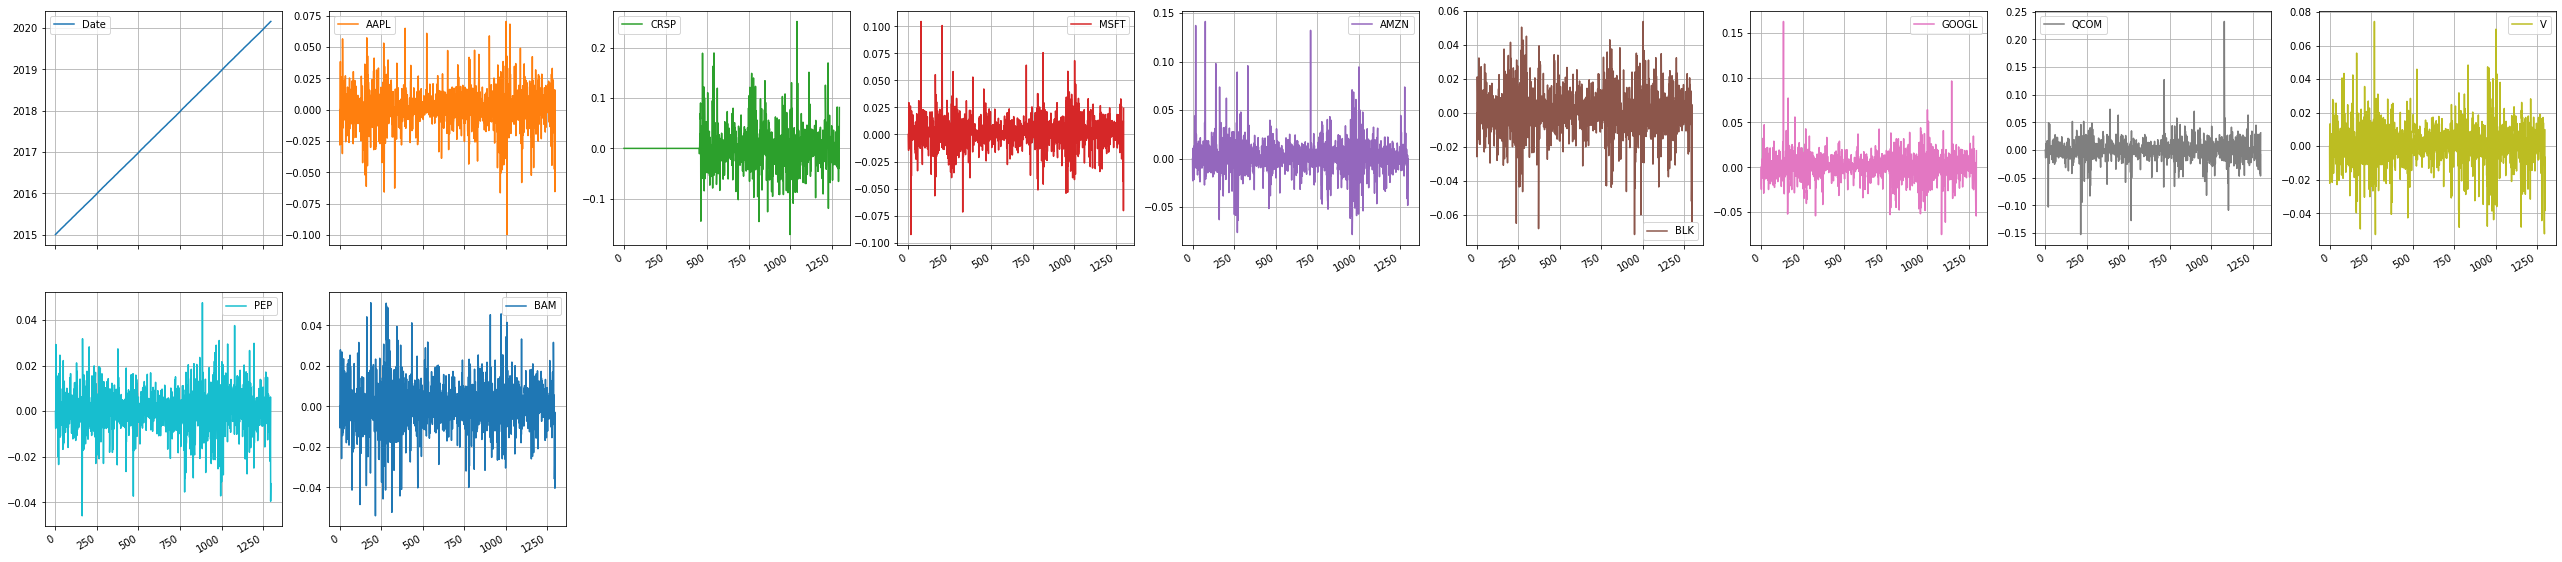

In [59]:
return_data.plot(subplots=True,
        grid=True, 
        layout=(8,9),
         figsize=(45,45)) # time series plots for each ticker
plt.show() # shows the plot and avoids the unwanted text before graph

In [60]:
del return_data["Date"] # the data is in order and hence timestamp is not needed

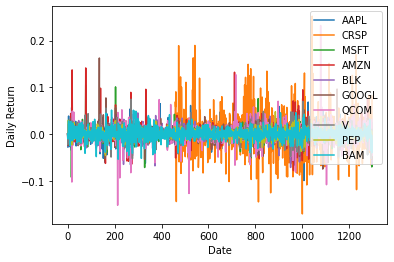

In [61]:
return_data.plot() # plotting the return_data to observe volatility
plt.xlabel("Date") # represents xlabel as date
plt.ylabel("Daily Return") # represents ylabel with Daily Return
plt.show()  # shows the plot and avoids the unwanted text before graph

**From the average return and standard deviation values below, it can be observed that the highest return is for the stocks CRSP & AMZN; however, the standard deviation is also high for CRSP in comparison to AMZN.**

In [62]:
Avg_Return = pd.DataFrame(np.mean(return_data) ,columns=["Avg_Return"]) # computes arithematic mean and assigning it to avg_return
print(Avg_Return) # prints avg_return
Std_Dev_Return = pd.DataFrame(np.std(return_data) ,columns=["Std_Dev_Return"]) # computes standard deviation of return_data and assigning it to Std_Dev_Return 
print(Std_Dev_Return) # prints Std_Dev_Return

       Avg_Return
AAPL     0.000899
CRSP     0.001622
MSFT     0.001153
AMZN     0.001563
BLK      0.000400
GOOGL    0.000827
QCOM     0.000377
V        0.000890
PEP      0.000414
BAM      0.000598
       Std_Dev_Return
AAPL         0.015833
CRSP         0.034759
MSFT         0.014874
AMZN         0.018438
BLK          0.014098
GOOGL        0.015047
QCOM         0.019947
V            0.013021
PEP          0.009185
BAM          0.012292


**The covariance matrix below will help in deciding the maximum risk limit for the model which worked out to be 0.0005**

In [63]:
# Below is the covariance matrix
Covariance_matrix = return_data.cov() # calculates the covariances from return_data
Covariance_matrix # displays the dataframe 

,AAPL,CRSP,MSFT,AMZN,BLK,GOOGL,QCOM,V,PEP,BAM
AAPL,0.000251,0.000114,0.000138,0.000142,0.000108,0.000126,0.000126,0.000113,0.000045,0.000081
CRSP,0.000114,0.001209,0.000123,0.000163,0.000074,0.000119,0.000117,0.000110,0.000004,0.000049
MSFT,0.000138,0.000123,0.000221,0.000171,0.000118,0.000147,0.000114,0.000131,0.000051,0.000092
AMZN,0.000142,0.000163,0.000171,0.000340,0.000106,0.000176,0.000095,0.000130,0.000039,0.000088
BLK,0.000108,0.000074,0.000118,0.000106,0.000199,0.000103,0.000122,0.000108,0.000049,0.000098
GOOGL,0.000126,0.000119,0.000147,0.000176,0.000103,0.000227,0.000096,0.000117,0.000043,0.000082
QCOM,0.000126,0.000117,0.000114,0.000095,0.000122,0.000096,0.000398,0.000096,0.000040,0.000078
V,0.000113,0.000110,0.000131,0.000130,0.000108,0.000117,0.000096,0.000170,0.000047,0.000085
PEP,0.000045,0.000004,0.000051,0.000039,0.000049,0.000043,0.000040,0.000047,0.000084,0.000046
BAM,0.000081,0.000049,0.000092,0.000088,0.000098,0.000082,0.000078,0.000085,0.000046,0.000151


In [64]:
return_data_cov = return_data.cov() # creating covariance table on stock return dataframe
print('Covariance Matrix:') # prints text Covariance Matrix:
print(return_data_cov) # prints the return_data_cov
print('\n') # returns/blank line

# these are the objective function COEFFICIENTS!
return_data_return = return_data.mean() # create the average of each stock
print('Average Return:') # prints text Average Return:
print(return_data_return) # prints the data

Covariance Matrix:
           AAPL      CRSP      MSFT  ...         V       PEP       BAM
AAPL   0.000251  0.000114  0.000138  ...  0.000113  0.000045  0.000081
CRSP   0.000114  0.001209  0.000123  ...  0.000110  0.000004  0.000049
MSFT   0.000138  0.000123  0.000221  ...  0.000131  0.000051  0.000092
AMZN   0.000142  0.000163  0.000171  ...  0.000130  0.000039  0.000088
BLK    0.000108  0.000074  0.000118  ...  0.000108  0.000049  0.000098
GOOGL  0.000126  0.000119  0.000147  ...  0.000117  0.000043  0.000082
QCOM   0.000126  0.000117  0.000114  ...  0.000096  0.000040  0.000078
V      0.000113  0.000110  0.000131  ...  0.000170  0.000047  0.000085
PEP    0.000045  0.000004  0.000051  ...  0.000047  0.000084  0.000046
BAM    0.000081  0.000049  0.000092  ...  0.000085  0.000046  0.000151

[10 rows x 10 columns]


Average Return:
AAPL     0.000899
CRSP     0.001622
MSFT     0.001153
AMZN     0.001563
BLK      0.000400
GOOGL    0.000827
QCOM     0.000377
V        0.000890
PEP      0.000

# **2: MODELS**

**Downloading the historical stock data from 2015 to March 2020 for modeling. This model once built will help to analyse the portfolio at different risk levels. Hence, we run this portfolio allocation model for different risk ceilings which are given as constraints during model building.**

In [65]:
from pyomo.environ import *

# declare the model
m = ConcreteModel() # define model as concretemodel

# defining variables
# each one is a stock (AAPL, CRSP, ,MSFT, AMZN, BLK, GOOGL, QCOM, V, PEP, BAM)
m.AAPL = Var(within=NonNegativeReals, bounds=(0,1)) # defining the ticker as a positive real number where below loops run with all real values starting between 0 and 1
m.CRSP = Var(within=NonNegativeReals, bounds=(0,1)) # defining the ticker as a positive real number where below loops run with all real values starting between 0 and 1
m.MSFT = Var(within=NonNegativeReals, bounds=(0,1)) # defining the ticker as a positive real number where below loops run with all real values starting between 0 and 1
m.AMZN = Var(within=NonNegativeReals, bounds=(0,1)) # defining the ticker as a positive real number where below loops run with all real values starting between 0 and 1
m.BLK = Var(within=NonNegativeReals, bounds=(0,1)) # defining the ticker as a positive real number where below loops run with all real values starting between 0 and 1
m.GOOGL = Var(within=NonNegativeReals, bounds=(0,1)) # defining the ticker as a positive real number where below loops run with all real values starting between 0 and 1
m.QCOM = Var(within=NonNegativeReals, bounds=(0,1)) # defining the ticker as a positive real number where below loops run with all real values starting between 0 and 1
m.V = Var(within=NonNegativeReals, bounds=(0,1)) # defining the ticker as a positive real number where below loops run with all real values starting between 0 and 1
m.PEP = Var(within=NonNegativeReals, bounds=(0,1)) # defining the ticker as a positive real number where below loops run with all real values starting between 0 and 1
m.BAM = Var(within=NonNegativeReals, bounds=(0,1)) # defining the ticker as a positive real number where below loops run with all real values starting between 0 and 1

## **Model Building**

**For the Optimization model building, we first specify the ConcreteModel. Then defining the decision variables and binding them (between 0 and 1) which is very important for a nonlinear solver. Also, adding constraints - sum of proportions (equal to 1), minimum return and maximum risk (no bound).**

**The minimum return is set to 0.005% as this is daily return and hence a very small value is considered. This value is calculated by asusming a minimum annual return of ~2%. After iterating the model for various return values, it has been observed that most of the stocks in the portfolio have a lower return and hence assumed a value of 0.005%.**

In [66]:
# declare objective
m.objective = Objective(expr =               
                        m.AAPL*return_data_return[0] + 
                        m.CRSP*return_data_return[1] + 
                        m.MSFT*return_data_return[2] +
                        m.AMZN*return_data_return[3] + 
                        m.BLK*return_data_return[4]+
                        m.GOOGL*return_data_return[5] + 
                        m.QCOM*return_data_return[6] + 
                        m.V*return_data_return[7] +
                        m.PEP*return_data_return[8] +
                        m.BAM*return_data_return[9],
                        sense=maximize) # objective is to maximize return of portfolio

# declare constraints

# 1. Sum of all porportions = 1
m.sum_proportions = Constraint(expr = m.AAPL + m.CRSP + m.MSFT + m.AMZN + m.BLK + m.GOOGL + m.QCOM + m.V + m.PEP + m.BAM == 1)

# 2. Minimum return should be 0.00005 or 0.005%
m.return_floor = Constraint(expr = m.objective >= 0.00005)

# 3. Setting maximum risk
m.total_risk = Constraint(expr = m.AAPL + m.CRSP + m.MSFT + m.AMZN + m.BLK + m.GOOGL + m.QCOM + m.V + m.PEP + m.BAM >= 0.0)

**Calculating the proportions based on above constraints, and setting the risk limits. We have chosen a smaller step size for granularity and precision while generating the efficient frontier.**

In [67]:
# creating calculations table for calculate the risk

# 3. Max risk should be less than 0.0015
max_risk = 0.0015
def calc_risk():
  
  proportions = [m.AAPL, m.CRSP, m.MSFT, m.AMZN, m.BLK, m.GOOGL, m.QCOM, m.V, m.PEP, m.BAM] # list of all of your investment allocations (proportion invested in each stock)
  risk_matrix = [] # an empty list
  
  # iterating across the covariance matrix
  for index, col in enumerate(return_data_cov.columns):
    i = 0
    risk = []
    for row in return_data_cov[col]:
      risk.append(proportions[index]*row*proportions[i]) # calculates the risk for a combination of stocks
      i = i + 1
    risk_matrix.append(risk)  # stores it to the risk_matrix
  risk_matrix = pd.DataFrame(risk_matrix)
  return risk_matrix.sum().sum() # returns the final risk value 

expr_risk = calc_risk() # computes risk

# Sequence of risk levels
risk_limits = np.arange(0.00001, 0.0015, 0.00002) # giving min, max risk levels and step size. This has been done for various combinations and finalized this combination
risk_limits # displays the array

array([1.00e-05, 3.00e-05, 5.00e-05, 7.00e-05, 9.00e-05, 1.10e-04,
       1.30e-04, 1.50e-04, 1.70e-04, 1.90e-04, 2.10e-04, 2.30e-04,
       2.50e-04, 2.70e-04, 2.90e-04, 3.10e-04, 3.30e-04, 3.50e-04,
       3.70e-04, 3.90e-04, 4.10e-04, 4.30e-04, 4.50e-04, 4.70e-04,
       4.90e-04, 5.10e-04, 5.30e-04, 5.50e-04, 5.70e-04, 5.90e-04,
       6.10e-04, 6.30e-04, 6.50e-04, 6.70e-04, 6.90e-04, 7.10e-04,
       7.30e-04, 7.50e-04, 7.70e-04, 7.90e-04, 8.10e-04, 8.30e-04,
       8.50e-04, 8.70e-04, 8.90e-04, 9.10e-04, 9.30e-04, 9.50e-04,
       9.70e-04, 9.90e-04, 1.01e-03, 1.03e-03, 1.05e-03, 1.07e-03,
       1.09e-03, 1.11e-03, 1.13e-03, 1.15e-03, 1.17e-03, 1.19e-03,
       1.21e-03, 1.23e-03, 1.25e-03, 1.27e-03, 1.29e-03, 1.31e-03,
       1.33e-03, 1.35e-03, 1.37e-03, 1.39e-03, 1.41e-03, 1.43e-03,
       1.45e-03, 1.47e-03, 1.49e-03])

**All the proportions for each risk levels are stored in the param_analysis. These values are further used to calculate the risk level while using the covariance values from the matrix above.**

In [68]:
# updating risk contraint for each limit and then solving the problem

param_analysis = {} # creating empty data structure to store allocations / proportions; key=risk, value = stock allocations 
returns = {} # creating empty data structure to store return values; key=risk, value = return
for r in risk_limits:
 
  m.del_component(m.total_risk) # removing risk component
  m.total_risk = Constraint(expr = expr_risk <= r) # redefining the total risk

  # running the solver
  result = SolverFactory('ipopt', executable=ipopt_executable).solve(m).write()

  # storing the allocation proportions of top 10 stocks to param_analysis data structure
  param_analysis[r] = [m.AAPL(), m.CRSP(), m.MSFT(), m.AMZN(), m.BLK(), m.GOOGL(), m.QCOM(), m.V(), m.PEP(), m.BAM()]
  
  # storing the returns of the top 10 stocks to returns data structure 
  returns[r] =  m.AAPL()*return_data_return[0] + m.CRSP()*return_data_return[1] + m.MSFT()*return_data_return[2] + m.AMZN()*return_data_return[3] + m.BLK()*return_data_return[4] + m.GOOGL()*return_data_return[5] + m.QCOM()*return_data_return[6] + m.V()*return_data_return[7] + m.PEP()*return_data_return[8] + m.BAM()*return_data_return[9]

    model.name="unknown";
      - termination condition: infeasible
      - message from solver: Ipopt 3.12.13\x3a Converged to a locally
        infeasible point. Problem may be infeasible.
# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time

## **Parameter Analysis**

**The following graph is between the risk and return / reward showing the optimal stock allocation for top 10 stocks at different risk levels. This graph has been used to filter those stocks with increasing returns at that specific risk level identified from the efficient frontier below.**

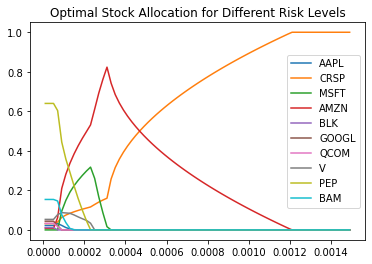

In [69]:
# generating the dataframe for proportions of the portfolio for each risk limit

param_analysis = pd.DataFrame.from_dict(param_analysis, orient='index') # converting into dataframe
param_analysis.columns = ["AAPL", "CRSP", "MSFT", "AMZN", "BLK", "GOOGL", "QCOM", "V", "PEP", "BAM"] # defining the columns
param_analysis.plot() # plotting the risk vs return plot based on allocations by the model
plt.title('Optimal Stock Allocation for Different Risk Levels')
plt.show() # displays the graph and avoid unwanted text above the graph

In [70]:
# subsetting the risks
risk = list(returns.keys()) # coercing dict_keys to a list
print(risk) # prints the risk values
reward = list(returns.values()) # coercing dict_values to a list called reward
print(reward) # printing reward

[1e-05, 3.0000000000000004e-05, 5.000000000000001e-05, 7.000000000000002e-05, 9.000000000000002e-05, 0.00011000000000000002, 0.00013000000000000004, 0.00015000000000000004, 0.00017000000000000004, 0.00019000000000000004, 0.00021000000000000004, 0.00023000000000000006, 0.00025000000000000006, 0.0002700000000000001, 0.0002900000000000001, 0.0003100000000000001, 0.0003300000000000001, 0.0003500000000000001, 0.0003700000000000001, 0.0003900000000000001, 0.0004100000000000001, 0.00043000000000000015, 0.00045000000000000015, 0.00047000000000000015, 0.0004900000000000001, 0.0005100000000000001, 0.0005300000000000002, 0.0005500000000000001, 0.0005700000000000002, 0.0005900000000000001, 0.0006100000000000002, 0.0006300000000000001, 0.0006500000000000002, 0.0006700000000000002, 0.0006900000000000002, 0.0007100000000000002, 0.0007300000000000002, 0.0007500000000000002, 0.0007700000000000002, 0.0007900000000000002, 0.0008100000000000002, 0.0008300000000000002, 0.0008500000000000003, 0.000870000000

## **Efficient Frontier**

**This graph is risk vs reward for the portfolio of top 10 stocks. From the efficient frontier, we can observe that at a risk of ~0.00029, maximum daily return of ~0.00158% is achieved and after that for any risk, there will be no betterment in the return (diminishing returns). Though it depends on the investor's risk appetite, it is wise to consider the point where the return reaches max and not change anymore! Hence, fo the evaluation of 2021 data, our team has decided to work on the risk level of 0.00029.**

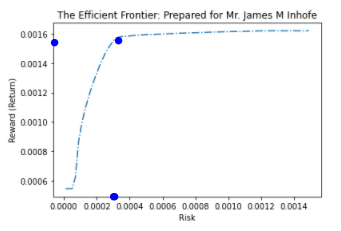


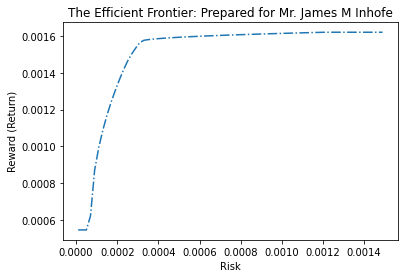

In [71]:
plot(risk, reward, '-.') # generates the risk vs reward plot
title('The Efficient Frontier: Prepared for Mr. James M Inhofe') # giving a plot title
xlabel('Risk') # representing xlabel as Risk
ylabel('Reward (Return)') # represents ylabel as Return
plt.show() # displays plot

# **3: EVALUATION**

**In the evaluation, we are trying to assess the return of tickers from the diversified portfolio. The return is calculated as the product of monthly growth in the stock over a certain period (post the date model is trained till today i.e., Mar-02-2020 till 01-Oct-2021) and the proportion of each stock in the portfolio at the target risk level. We have tried evaluating two scenarios which are explained below:**

In [72]:
ticker_list = top10sector["ticker"] # storing the list of tickers from top10sector dataframe

# extracting daily historical price data for each stocks 

histdata = {ticker : si.get_data(ticker, start_date = '03/02/2020', end_date='11/01/2021', interval='1mo') for ticker in ticker_list} # retrieving monthly stocks data from 2nd March 2020 to 1st Oct 2021
histdata # displays the data dictionary 

{'AAPL':                   open        high         low  ...    adjclose      volume  ticker
 2020-03-01   70.570000   76.000000   53.152500  ...   62.790684  6280072400    AAPL
 2020-04-01   61.625000   73.632500   59.224998  ...   72.546700  3265299200    AAPL
 2020-05-01   71.562500   81.059998   71.462502  ...   78.507500  2805936000    AAPL
 2020-06-01   79.437500   93.095001   79.302498  ...   90.322250  3243375600    AAPL
 2020-07-01   91.279999  106.415001   89.144997  ...  105.237312  3020283200    AAPL
 2020-08-01  108.199997  131.000000  107.892502  ...  127.798073  4070061100    AAPL
 2020-09-01  132.759995  137.979996  103.099998  ...  114.902191  3885245100    AAPL
 2020-10-01  117.639999  125.389999  107.720001  ...  108.006676  2894666500    AAPL
 2020-11-01  109.110001  121.989998  107.320000  ...  118.116798  2123077300    AAPL
 2020-12-01  121.010002  138.789993  120.010002  ...  131.876999  2322189600    AAPL
 2021-01-01  133.520004  145.089996  126.379997  ...  131

**Retrieving only the adjusted close price on first of each month from the historical data dictionary in the above code**

In [73]:
 ajdclosedata = pd.DataFrame(histdata["AAPL"]["adjclose"]).rename(columns = {"adjclose":"AAPL"}) # creating adjclosedata dataframe

# combine all the tickers (all the rest of the samples)

for i in ticker_list[1:]:
  ajdclosedata[i] = pd.DataFrame(histdata[i]["adjclose"]) # runs the loop for all the values in tickers list
ajdclosedata # displays the data dictionary

,AAPL,CRSP,MSFT,AMZN,BLK,GOOGL,QCOM,V,PEP,BAM
2020-03-01,62.790684,42.410000,155.182266,1949.719971,420.699585,1161.949951,64.767372,159.387161,113.386383,28.909979
2020-04-01,72.546700,49.200001,176.337646,2474.000000,483.693176,1346.699951,75.916939,176.797897,125.738297,33.143570
2020-05-01,78.507500,64.580002,180.312912,2442.370117,509.321075,1433.520020,78.049591,193.140228,125.034950,30.732777
2020-06-01,90.322250,73.489998,200.805893,2758.820068,524.206482,1418.050049,88.018089,191.412430,125.709778,32.362740
2020-07-01,105.237312,85.459999,202.285965,3164.679932,557.692688,1487.949951,102.702972,188.667633,131.857941,31.802044
2020-08-01,127.798073,93.459999,222.533310,3450.959961,576.295044,1629.530029,115.821648,210.061203,134.156784,33.189018
2020-09-01,114.902191,83.639999,208.036957,3148.729980,546.577881,1465.599976,114.440742,198.450134,132.758316,32.632938
2020-10-01,108.006676,91.820000,200.262665,3036.149902,584.654541,1616.109985,120.606911,180.328934,128.590164,29.395309
2020-11-01,118.116798,126.919998,211.736176,3168.040039,681.386230,1754.400024,143.885513,208.751221,139.144424,39.966961
2020-12-01,131.876999,153.110001,220.571106,3256.929932,704.013000,1752.640015,148.940155,217.394608,143.070923,40.854847


## **Case I: Continuing with all the top 10 stocks in the portfolio**

**Calculating the cumulative annual growth rate between the latest and oldest dates**

In [74]:
return_data = pd.DataFrame(((ajdclosedata.iloc[-1,:]/ajdclosedata.iloc[0,:])-1)*100).reset_index() # calculating the percentage change in growth for the 20 month span
return_data # displays the dataframe

,index,0
0,AAPL,138.222753
1,CRSP,115.350158
2,MSFT,113.306850
3,AMZN,72.969964
4,BLK,123.230189
5,GOOGL,154.823361
6,QCOM,104.638464
7,V,32.631672
8,PEP,41.564927
9,BAM,108.417952


**Renaming the columns and bringing out a useful dataframe**

In [75]:
return_data.rename(columns={"index": "ticker", 0: "Monthly growth"},inplace=True) # renaming the columns names in the return_data dataframe
return_data.sort_values("Monthly growth", ascending = False, inplace=True) # sorting the monthly growth in descending order
return_data.reset_index(drop=True, inplace=True) # resetting index
return_data # displays the dataframe

,ticker,Monthly growth
0,GOOGL,154.823361
1,AAPL,138.222753
2,BLK,123.230189
3,CRSP,115.350158
4,MSFT,113.306850
5,BAM,108.417952
6,QCOM,104.638464
7,AMZN,72.969964
8,PEP,41.564927
9,V,32.631672


**Viewing the proportions at each risk level and extracting the proportions at targeted risk level from the efficient frontier**

In [76]:
param_analysis.head(15) # displays 15 rows of  param_analysis i.e., allocations / proportions

,AAPL,CRSP,MSFT,AMZN,BLK,GOOGL,QCOM,V,PEP,BAM
0.00001,0.022493,0.032108,7.659324e-08,0.008641,0.012069,0.044136,0.033285,0.053274,0.639900,0.154094
0.00003,0.022491,0.032108,1.407364e-07,0.008647,0.012076,0.044133,0.033285,0.053270,0.639899,0.154091
0.00005,0.022493,0.032108,8.241863e-08,0.008641,0.012069,0.044136,0.033285,0.053273,0.639900,0.154094
0.00007,0.032435,0.039923,4.133715e-05,0.062223,0.000015,0.020702,0.017469,0.077206,0.603680,0.146307
0.00009,0.022675,0.063561,9.510712e-02,0.209987,0.000008,0.000019,0.000012,0.087502,0.444271,0.076857
0.00011,0.011987,0.075152,1.497205e-01,0.282069,0.000003,0.000005,0.000003,0.085851,0.358176,0.037034
0.00013,0.004908,0.084080,1.913539e-01,0.337533,0.000007,0.000014,0.000008,0.083922,0.290859,0.007314
0.00015,0.001197,0.091809,2.239091e-01,0.384585,0.000007,0.000013,0.000007,0.075716,0.222536,0.000220
0.00017,0.000333,0.098629,2.511132e-01,0.425803,0.000007,0.000013,0.000007,0.065807,0.158205,0.000082
0.00019,0.000092,0.104767,2.754821e-01,0.462906,0.000003,0.000004,0.000003,0.056667,0.100055,0.000022


**Resetting the index to filter the required rows**

In [77]:
param_analysis.reset_index(inplace=True) # resetting the index
param_analysis.rename(columns={"index": "risk"},inplace=True) # renaming the column
param_analysis.head(15) # displays first 15 rows of param_analysis

,risk,AAPL,CRSP,MSFT,AMZN,BLK,GOOGL,QCOM,V,PEP,BAM
0,0.00001,0.022493,0.032108,7.659324e-08,0.008641,0.012069,0.044136,0.033285,0.053274,0.639900,0.154094
1,0.00003,0.022491,0.032108,1.407364e-07,0.008647,0.012076,0.044133,0.033285,0.053270,0.639899,0.154091
2,0.00005,0.022493,0.032108,8.241863e-08,0.008641,0.012069,0.044136,0.033285,0.053273,0.639900,0.154094
3,0.00007,0.032435,0.039923,4.133715e-05,0.062223,0.000015,0.020702,0.017469,0.077206,0.603680,0.146307
4,0.00009,0.022675,0.063561,9.510712e-02,0.209987,0.000008,0.000019,0.000012,0.087502,0.444271,0.076857
5,0.00011,0.011987,0.075152,1.497205e-01,0.282069,0.000003,0.000005,0.000003,0.085851,0.358176,0.037034
6,0.00013,0.004908,0.084080,1.913539e-01,0.337533,0.000007,0.000014,0.000008,0.083922,0.290859,0.007314
7,0.00015,0.001197,0.091809,2.239091e-01,0.384585,0.000007,0.000013,0.000007,0.075716,0.222536,0.000220
8,0.00017,0.000333,0.098629,2.511132e-01,0.425803,0.000007,0.000013,0.000007,0.065807,0.158205,0.000082
9,0.00019,0.000092,0.104767,2.754821e-01,0.462906,0.000003,0.000004,0.000003,0.056667,0.100055,0.000022


**Proportions at target risk level**

image.png
image.png


**Since the risk level is float with much more decimal values, we are trying to give a range to filter the risk level of ~0.00029.**

In [78]:
dfrisk = param_analysis[(param_analysis["risk"]>0.00028) & (param_analysis["risk"]<0.00030)] # filtering the proportions for a risk of 0.00029

**Transposing the horizontal dataframe and bringing out a useful one to merge with the return data dataframe**

In [79]:
dfrisk = dfrisk.T # transposing the dataframe
dfrisk.reset_index(inplace=True) # resetting index
dfrisk.rename(columns={"index": "ticker", 14: "Proportion"},inplace=True) # renaimg the columns 
dfrisk # displays the dataframe

,ticker,Proportion
0,risk,0.000290
1,AAPL,0.000017
2,CRSP,0.151172
3,MSFT,0.087255
4,AMZN,0.761502
5,BLK,0.000005
6,GOOGL,0.000008
7,QCOM,0.000004
8,V,0.000020
9,PEP,0.000008


**Merging the return (growth rate) and the proportion dataframes on ticker**

In [80]:
return_proportion = pd.merge(return_data, dfrisk, on="ticker", how="left") # left join of return_data and dfrisk on ticker
return_proportion # displays the return_proportion dataframe

,ticker,Monthly growth,Proportion
0,GOOGL,154.823361,0.000008
1,AAPL,138.222753,0.000017
2,BLK,123.230189,0.000005
3,CRSP,115.350158,0.151172
4,MSFT,113.306850,0.087255
5,BAM,108.417952,0.000009
6,QCOM,104.638464,0.000004
7,AMZN,72.969964,0.761502
8,PEP,41.564927,0.000008
9,V,32.631672,0.000020


**As mentioned above, we are computing the return by multiplying the proportion of each stock in the portfolio at target risk level and growth rate.**

In [81]:
return_proportion["return"] = return_proportion["Monthly growth"]*return_proportion["Proportion"] # computing return_proportion by multiplying monthly_growth and Proportion
return_proportion # displays the dataframe

,ticker,Monthly growth,Proportion,return
0,GOOGL,154.823361,0.000008,0.001229
1,AAPL,138.222753,0.000017,0.002294
2,BLK,123.230189,0.000005,0.000564
3,CRSP,115.350158,0.151172,17.437759
4,MSFT,113.306850,0.087255,9.886539
5,BAM,108.417952,0.000009,0.000967
6,QCOM,104.638464,0.000004,0.000465
7,AMZN,72.969964,0.761502,55.566809
8,PEP,41.564927,0.000008,0.000334
9,V,32.631672,0.000020,0.000654


**The sum of return column is obtained**

In [82]:
return_proportion["return"].sum() # aggregating the return column

82.89761506156206

**This sum is the return from the portfolio over a period of 20 months. However, in order to compare the same with the efficient frontier from the model, it is required to divide the same for 578 days (no. of days in 20 months). his results in approximately 0.00143 i.e., 0.1483% per day. By cross verifying the same with the model efficient frontier against risk level of ~ 0.0029, return is approximatey in the range of 0.0014 - 0.0016 which says the real-time data is giving expected return from model**

## **Case II: Narrowing down the stocks that are increasing against the risk level of ~0.00029 in the efficient frontier**
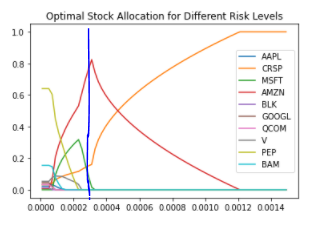

**Only two stocks are growing at the target risk level and hence diversifying the portoflio to only those two stocks.**

In [83]:
new_stocks = ["CRSP", "AMZN"] # selecting only those stocks with positive return
new_proportion = dfrisk[dfrisk["ticker"].isin(new_stocks)] # extracting the proportions 
new_proportion # displays the dataframe

,ticker,Proportion
2,CRSP,0.151172
4,AMZN,0.761502


**Since the proportion doesn't sum up to 100, we are adjusting the proportions by their own weights to obtain the adjusted proportions for calculating return.**

In [84]:
new_proportion["Proportion_adj"] = new_proportion["Proportion"] / new_proportion["Proportion"].sum() # reallocating the proportions for only 2 stocks in the portfolio
new_proportion # displays the dataframe

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,ticker,Proportion,Proportion_adj
2,CRSP,0.151172,0.165637
4,AMZN,0.761502,0.834363


**Similar to Case I, we are now merging the return dataframe and the new proportion dataframe to calculate the overall return.**

In [85]:
return_proportionnew = pd.merge(return_data, new_proportion, on="ticker", how="right") # merging the return data with proportions on ticker
return_proportionnew["returnnew"] = return_proportionnew["Monthly growth"]*return_proportionnew["Proportion_adj"] # adding a new column to calculate the return in case II
return_proportionnew # displays the dataframe

,ticker,Monthly growth,Proportion,Proportion_adj,returnnew
0,CRSP,115.350158,0.151172,0.165637,19.106212
1,AMZN,72.969964,0.761502,0.834363,60.883465


**The sum of return column is obtained**

In [86]:
return_proportionnew["returnnew"].sum()

79.9896766681857

**This sum is the overall return from the portfolio over a period of 20 months. However, in order to compare the same with the efficient frontier from the model, it is required to divide the same for 578 days (number of days in 20 months). This results in approximately 0.00138 i.e., 0.138% per day. By cross verifying the same with the model efficient frontier against risk level of ~ 0.00029, return is approximatey in the range of 0.0014 - 0.0016  which says the real-time data is giving expected return from model.**

# **4: CONCLUSIONS**

1. Based on the above analysis we can say that the return from Case I is higher than in Case II by approximately 6.25%. Though the return in the latter case is lower; it is wise to go ahead with only two stocks (based on the growth in risk vs reward graph) in contradiction to the overall return. We know the unpredictable nature of stock market!

2. We learned how to handle time series data and quantify a value for different timelines like monthly and daily. We learned the significance of different risk levels, co-variance matrix, and efficient frontiers. We would like to apply these techniques in real-time.

3. When we reached a dip during the start of Covid-19 in March 2020 (plot 5), every stock experienced fall except Amazon stock. We performed good analysis and able to find out that the Amazon is one of the top 10 stocks. As per our model, Amazon is one of the top two stocks.

4. From the analysis we understood that it is important to understand the stock's behavior over a period. Also, there should be a decision supporting criteria to pick a stock to the portfolio.  

5. The team opines that volatility can be one of the best measures to see the percentage change in value wrt the previous day. Also, each stock's volatile nature can be compared to the other stocks.  

6. Looking at the current active stocks in the senator's portfolio, We learnt that it depends on the risk appetite of the investor to choose a stock! Low risk-low gain or high-risk high gain!

7. From the param_analysis table where all the proportions are assigned by the model for various risk levels, we observed that lesser is the risk level, diverisified is the portfolio and vice versa! 

Did the Senator help you do better than investing in the S&P 500 or Dow Jones Index?

8. Dow_Jones Index (DJI): The average daily return from the DJI for the period of Mar-02-2020 till Oct-01-2021 is 0.049%. 

9. S & P 500: The average daily return from the DJI for the period of Mar-02-2020 till Oct-01-2021 is 0.071%.

10. In comparison to the average daily returns of S&P 500, DJI, senator's portoolio has given better returns in the said period in both Case I & II. The average daily return from portfolio is ~0.14% which is double to both the index returns.

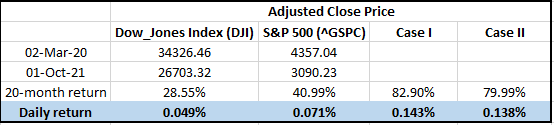





# **5: SOURCES & REFERENCES**

SenatOr's portfolio

https://senatestockwatcher.com/summary_by_senator/James%20M%20Inhofe

Downloading real-time stock data from Yahoo Finance API

https://drive.google.com/file/d/1cQxGg7hdXfqMaUyBmYTk8kH9JTTwLLJR/view?usp=sharing 

Sectors, Industry & Stock price details

https://finance.yahoo.com/
https://datahub.io/core/s-and-p-500-companies
https://finance.yahoo.com/quote/%5EDJI/history?period1=1583107200&period2=1633305600&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true
https://finance.yahoo.com/quote/%5EGSPC/history?period1=1583107200&period2=1633305600&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true




